In [63]:
import os
import importlib

import chess
import chess.svg
from jax import random as jrandom
import jax
import jax.nn as jnn
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt

from matplotlib import colors
from matplotlib import gridspec
import pickle
import json
import gc

import networkx as nx


#os.chdir("/mnt/homeGPU/jorgelerre/S-ChessFormer")

In [64]:
from searchless_chess.src import transformer_xai
importlib.reload(transformer_xai)
from searchless_chess.src import tokenizer
from searchless_chess.src import training_utils
from searchless_chess.src import utils
from searchless_chess.src.engines import engine
from searchless_chess.src.engines import neural_engines
import searchless_chess.src.engines.constants as constants

In [65]:
# @title Create the predictor (9M)
policy = 'action_value'
num_return_buckets = 128
num_heads = 8
num_layers = 8
embedding_dim = 256

output_size = num_return_buckets
predictor_config = transformer_xai.TransformerConfig(
    vocab_size=utils.NUM_ACTIONS,
    output_size=output_size,
    pos_encodings=transformer_xai.PositionalEncodings.LEARNED,
    max_sequence_length=tokenizer.SEQUENCE_LENGTH + 2,
    num_heads=num_heads,
    num_layers=num_layers,
    embedding_dim=embedding_dim,
    apply_post_ln=True,
    apply_qk_layernorm=False,
    use_causal_mask=False,
)

predictor = transformer_xai.build_transformer_predictor(config=predictor_config)

In [66]:
# @title Load the predictor parameters
os.chdir("/mnt/homeGPU/jorgelerre/S-ChessFormer")
checkpoint_dir = os.path.join(
    os.getcwd(),
    f'searchless_chess/checkpoints/9M',
)
dummy_params = predictor.initial_params(
    rng=jrandom.PRNGKey(6400000),
    targets=np.zeros((1, 1), dtype=np.uint32),
)
params = training_utils.load_parameters(
    checkpoint_dir=checkpoint_dir,
    params=dummy_params,
    use_ema_params=True,
    step=-1,
)

In [67]:
# @title Create the engine
batch_size = 1
jitted_predict_fn = jax.jit(predictor.predict)

def fixed_predict_fn(sequences: np.ndarray) -> np.ndarray:
    """Wrapper around the predictor `predict` function."""
    assert sequences.shape[0] == batch_size
    return jitted_predict_fn(
        params=params,
        targets=sequences,
        rng=None,
    )

def predict_fn(sequences: np.ndarray) -> np.ndarray:
    """Wrapper to collate batches of sequences of fixed size."""
    remainder = -len(sequences) % batch_size
    padded = np.pad(sequences, ((0, remainder), (0, 0)))
    sequences_split = np.split(padded, len(padded) // batch_size)
    all_outputs = []
    for sub_sequences in sequences_split:
        all_outputs.append(fixed_predict_fn(sub_sequences))
    return all_outputs #outputs[: len(sequences)]  # Crop the padded sequences.


- Visualizar capas de atención 
- Heatmaps sobre el tablero
- Integrated Gradients
- SHAP
- Probing

In [44]:
print(jax.devices())

[CudaDevice(id=0)]


## Visualización de pesos

In [45]:
print('Parametros de 9M:')
print(params.keys())
print('embed:')
print(params['embed'].keys())
print(params['embed']['embeddings'].shape)
print('embed posicional:')
print(params['embed_1'].keys())
print(params['embed_1']['embeddings'].shape)
print('layer_norm:')
print(params['layer_norm'].keys())
print(params['layer_norm']['offset'].shape)
print(params['layer_norm']['scale'].shape)
print('linear:')
print(params['linear'].keys())
print(params['linear']['w'].shape)
print('multi_head_dot_product_attention/linear')
print(params['multi_head_dot_product_attention/linear'].keys())
print(params['multi_head_dot_product_attention/linear']['w'].shape)

Parametros de 9M:
dict_keys(['embed', 'embed_1', 'layer_norm', 'layer_norm_1', 'layer_norm_10', 'layer_norm_11', 'layer_norm_12', 'layer_norm_13', 'layer_norm_14', 'layer_norm_15', 'layer_norm_16', 'layer_norm_2', 'layer_norm_3', 'layer_norm_4', 'layer_norm_5', 'layer_norm_6', 'layer_norm_7', 'layer_norm_8', 'layer_norm_9', 'linear', 'linear_1', 'linear_10', 'linear_11', 'linear_12', 'linear_13', 'linear_14', 'linear_15', 'linear_16', 'linear_17', 'linear_18', 'linear_19', 'linear_2', 'linear_20', 'linear_21', 'linear_22', 'linear_23', 'linear_24', 'linear_3', 'linear_4', 'linear_5', 'linear_6', 'linear_7', 'linear_8', 'linear_9', 'multi_head_dot_product_attention/linear', 'multi_head_dot_product_attention/linear_1', 'multi_head_dot_product_attention/linear_2', 'multi_head_dot_product_attention/linear_3', 'multi_head_dot_product_attention_1/linear', 'multi_head_dot_product_attention_1/linear_1', 'multi_head_dot_product_attention_1/linear_2', 'multi_head_dot_product_attention_1/linear_3

### Embeddings

#### Posicional

In [46]:
pos_labels = ['<start>',
            'a8', 'b8', 'c8', 'd8', 'e8', 'f8', 'g8', 'h8',
            'a7', 'b7', 'c7', 'd7', 'e7', 'f7', 'g7', 'h7',
            'a6', 'b6', 'c6', 'd6', 'e6', 'f6', 'g6', 'h6',
            'a5', 'b5', 'c5', 'd5', 'e5', 'f5', 'g5', 'h5',
            'a4', 'b4', 'c4', 'd4', 'e4', 'f4', 'g4', 'h4',
            'a3', 'b3', 'c3', 'd3', 'e3', 'f3', 'g3', 'h3',
            'a2', 'b2', 'c2', 'd2', 'e2', 'f2', 'g2', 'h2',
            'a1', 'b1', 'c1', 'd1', 'e1', 'f1', 'g1', 'h1',
            '<turn>', 
            '<castling_1>', '<castling_2>', '<castling_3>', '<castling_4>',
            '<en_passant_letter>','<en_passant_number>',
            '<halfmove_1>', '<halfmove_2>', '<halfmove_3>',
            '<fullmove_1>', '<fullmove_2>', '<fullmove_3>', 
            'move']
len(pos_labels)

79

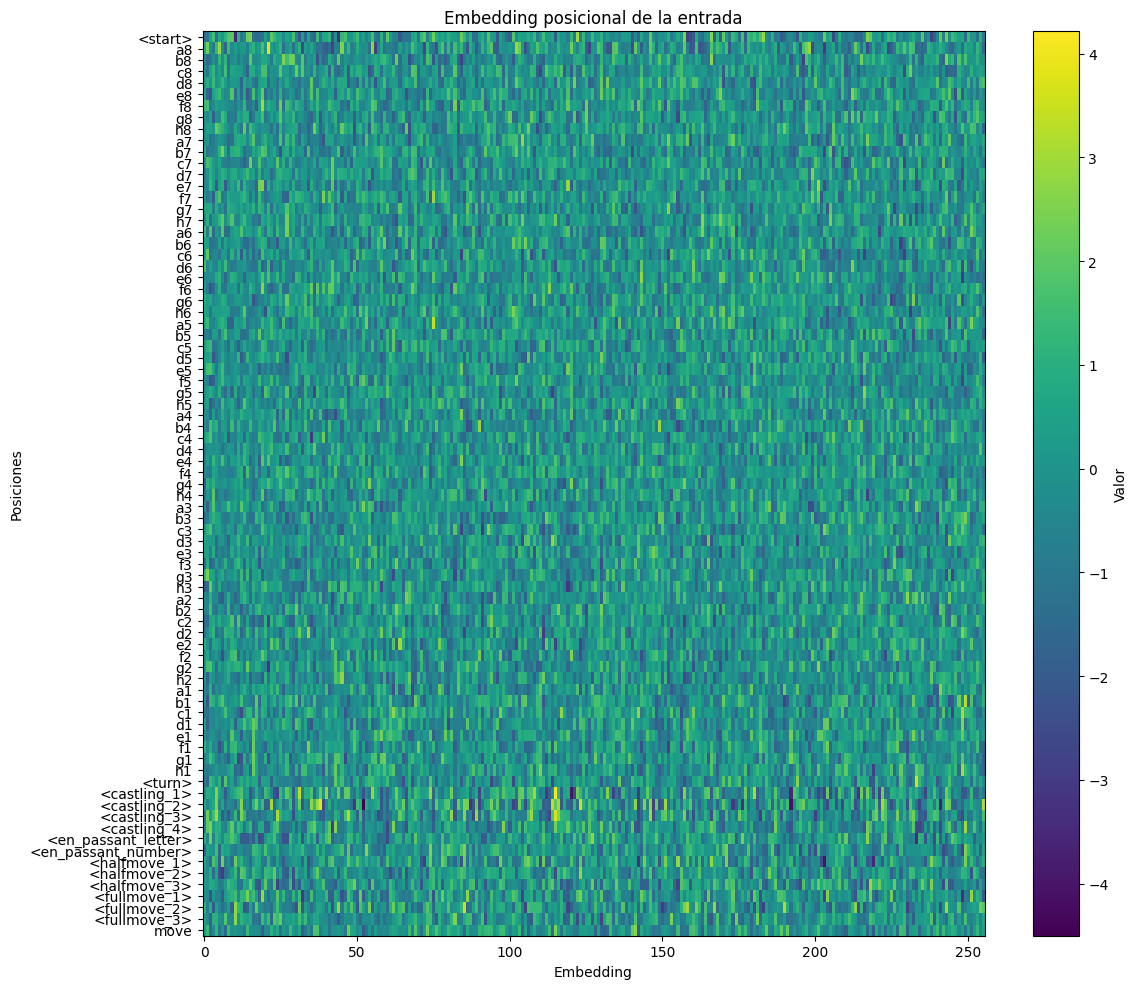

In [47]:
plt.figure(figsize=(12, 10))
plt.imshow(params['embed_1']['embeddings'], aspect='auto', cmap='viridis') 
plt.colorbar(label='Valor')
plt.title('Embedding posicional de la entrada')
plt.xlabel('Embedding')
plt.ylabel('Posiciones')

yticks = np.arange(len(pos_labels))
yticklabels = pos_labels
plt.yticks(ticks=yticks, labels=yticklabels)

plt.tight_layout()
plt.show()

In [48]:
# Calcular la distancia entre los embeddings de cada token

data = params['embed_1']['embeddings']
distances_pos_embedding = np.zeros((data.shape[0], data.shape[0]))

for i in range(data.shape[0]):
    if i % 10 == 0:
        print(i)
    for j in range(i+1, data.shape[0]):
        distances_pos_embedding[i,j] = np.linalg.norm(data[i] - data[j])
        
for i in range(data.shape[0]):
    for j in range(i+1):
        distances_pos_embedding[i,j] = distances_pos_embedding[j,i]
#np.save('distances_between_pos_embeddings.npy', distances_pos_embedding)

0
10
20
30
40
50
60
70


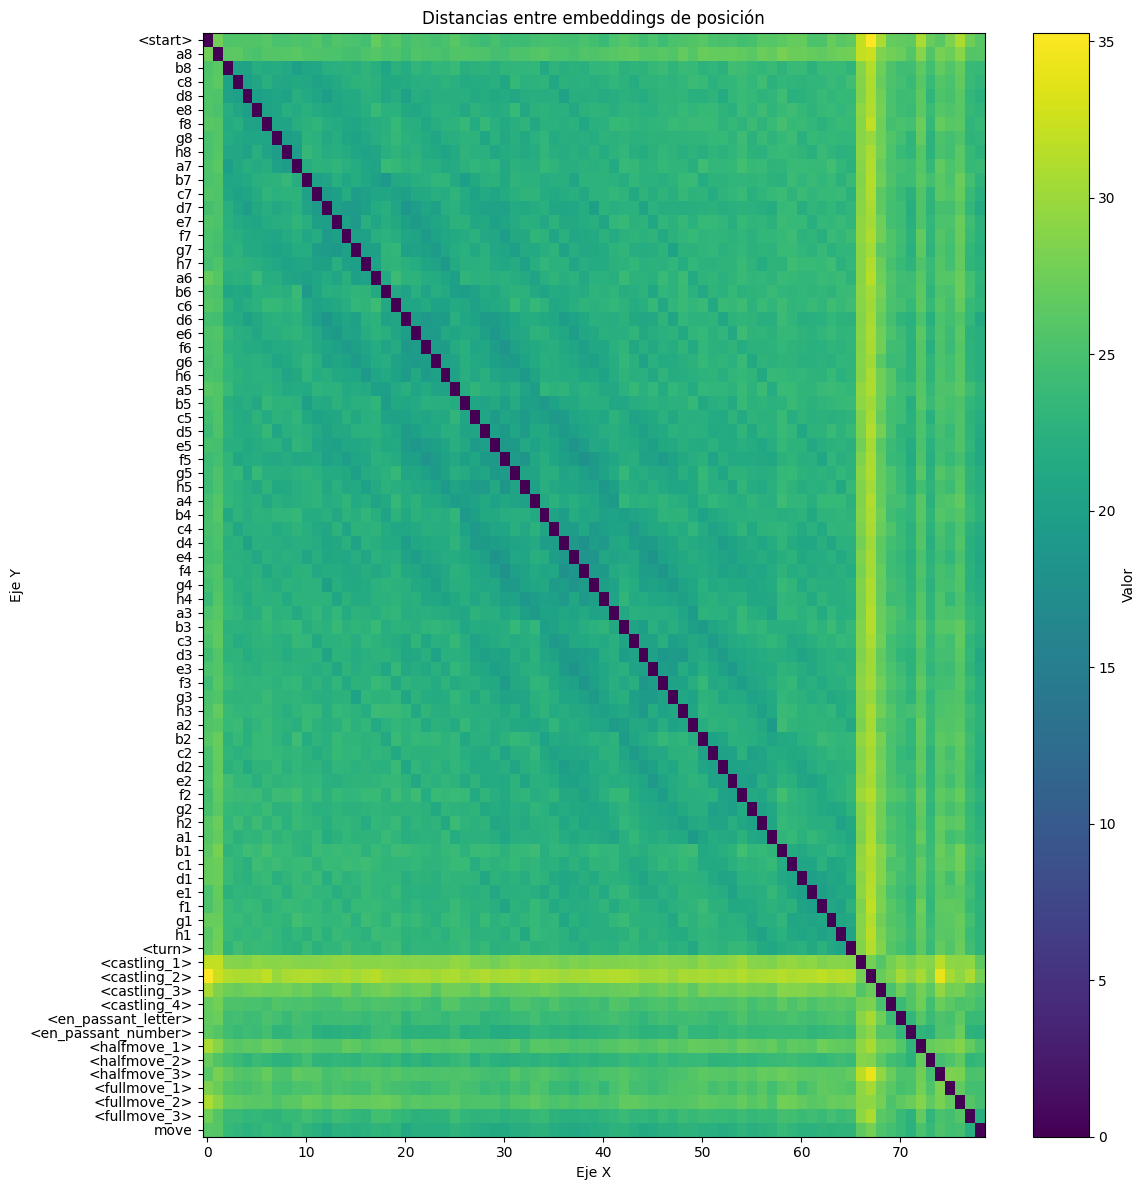

In [49]:
# Crear el mapa de calor con las distancias entre embeddings
plt.figure(figsize=(12, 12))
plt.imshow(distances_pos_embedding, aspect='auto', cmap='viridis')  
plt.colorbar(label='Valor')
plt.title('Distancias entre embeddings de posición')
plt.xlabel('Eje X')
plt.ylabel('Eje Y')

yticks = np.arange(len(pos_labels))
yticklabels = pos_labels
plt.yticks(ticks=yticks, labels=yticklabels)

plt.tight_layout()
plt.show()

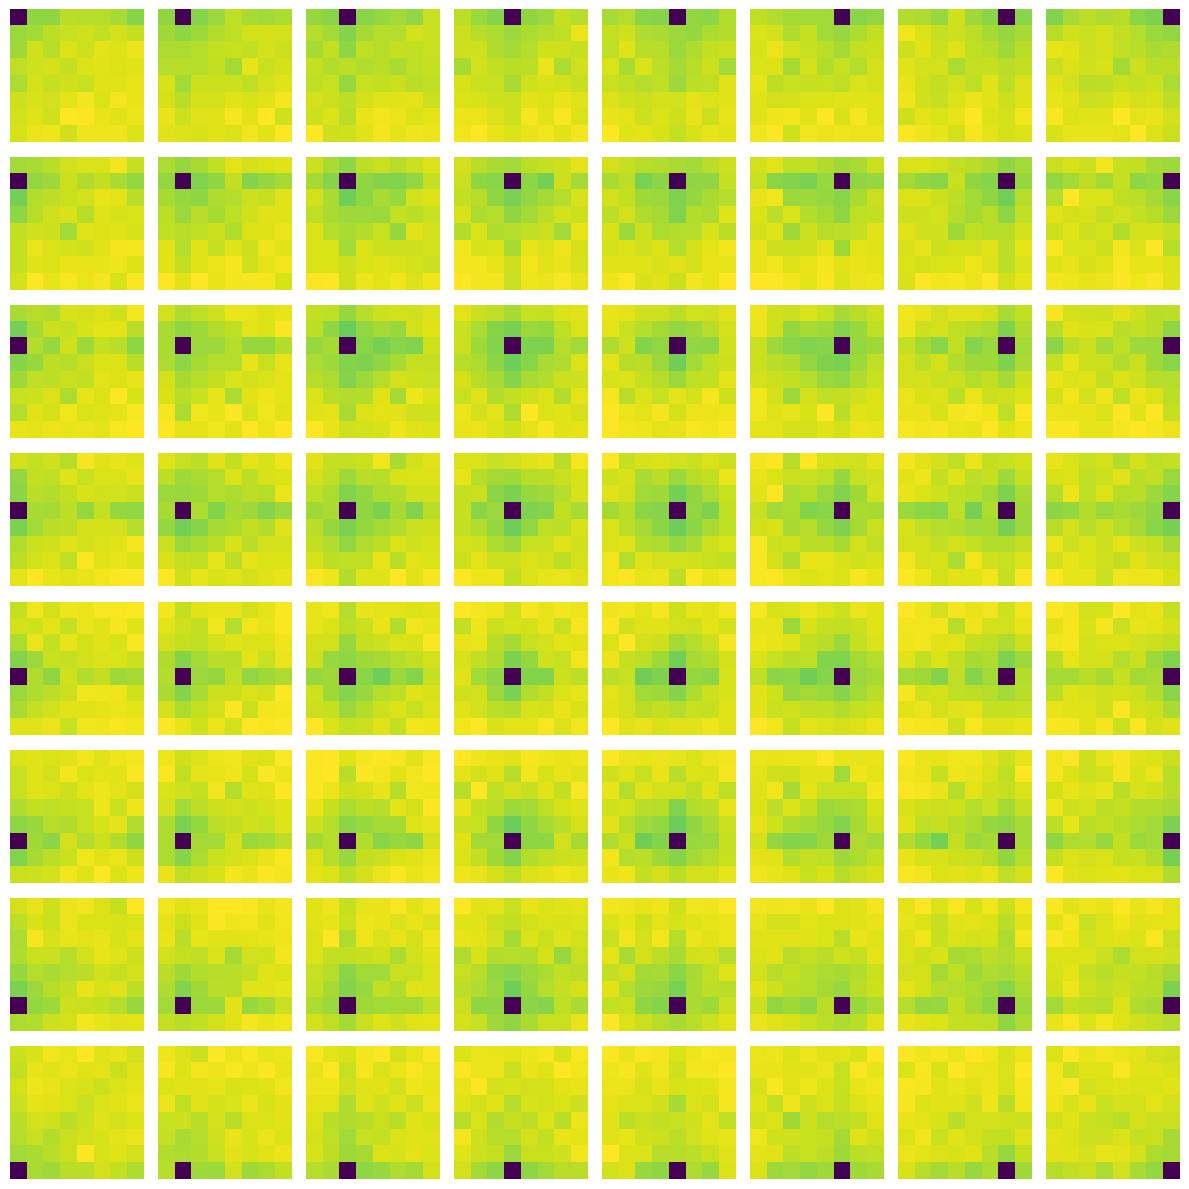

In [50]:
pos_ini = 2
pos_fin = 66
distancias_tablero = distances_pos_embedding[pos_ini:pos_fin,pos_ini:pos_fin]

# Crear figura con 8x8 subplots
fig, axes = plt.subplots(8, 8, figsize=(12, 12))

# Iterar sobre cada bloque 8x8
for i in range(8):
    for j in range(8):
        pos_actual = i*8 + j
        block = distancias_tablero[i*8 + j].reshape(8, 8)
        ax = axes[i, j]
        im = ax.imshow(block, cmap='viridis')
        ax.axis('off')
        

plt.tight_layout()
plt.show()

#### Vocabulario

In [51]:
# Creamos un diccionario para saber qué significa cada token
from collections import defaultdict

y_labels_dict = defaultdict(list)

for i in range(len(utils.ACTION_TO_MOVE.items())):
    y_labels_dict[i] = [str(i)]
    
# Mezclamos el primer diccionario
for v, k in tokenizer._CHARACTERS_INDEX.items():
    y_labels_dict[k].append(v)
    
# Mezclamos el segundo diccionario (invertido del tokenizer)
for k, v in utils.ACTION_TO_MOVE.items():
    y_labels_dict[k].append(v)

# Convertimos de nuevo a un diccionario normal (opcional)
y_labels_dict = {k: '/'.join(v) for k, v in y_labels_dict.items()}

print(y_labels_dict)

{0: '0/0/a1b1', 1: '1/1/a1c1', 2: '2/2/a1d1', 3: '3/3/a1e1', 4: '4/4/a1f1', 5: '5/5/a1g1', 6: '6/6/a1h1', 7: '7/7/a1a2', 8: '8/8/a1b2', 9: '9/9/a1a3', 10: '10/a/a1c3', 11: '11/b/a1a4', 12: '12/c/a1d4', 13: '13/d/a1a5', 14: '14/e/a1e5', 15: '15/f/a1a6', 16: '16/g/a1f6', 17: '17/h/a1a7', 18: '18/p/a1g7', 19: '19/n/a1a8', 20: '20/r/a1h8', 21: '21/k/a1c2', 22: '22/q/a1b3', 23: '23/P/b1a1', 24: '24/B/b1c1', 25: '25/N/b1d1', 26: '26/R/b1e1', 27: '27/Q/b1f1', 28: '28/K/b1g1', 29: '29/w/b1h1', 30: '30/./b1a2', 31: '31/b1b2', 32: '32/b1c2', 33: '33/b1b3', 34: '34/b1d3', 35: '35/b1b4', 36: '36/b1e4', 37: '37/b1b5', 38: '38/b1f5', 39: '39/b1b6', 40: '40/b1g6', 41: '41/b1b7', 42: '42/b1h7', 43: '43/b1b8', 44: '44/b1d2', 45: '45/b1a3', 46: '46/b1c3', 47: '47/c1a1', 48: '48/c1b1', 49: '49/c1d1', 50: '50/c1e1', 51: '51/c1f1', 52: '52/c1g1', 53: '53/c1h1', 54: '54/c1b2', 55: '55/c1c2', 56: '56/c1d2', 57: '57/c1a3', 58: '58/c1c3', 59: '59/c1e3', 60: '60/c1c4', 61: '61/c1f4', 62: '62/c1c5', 63: '63/c1g5

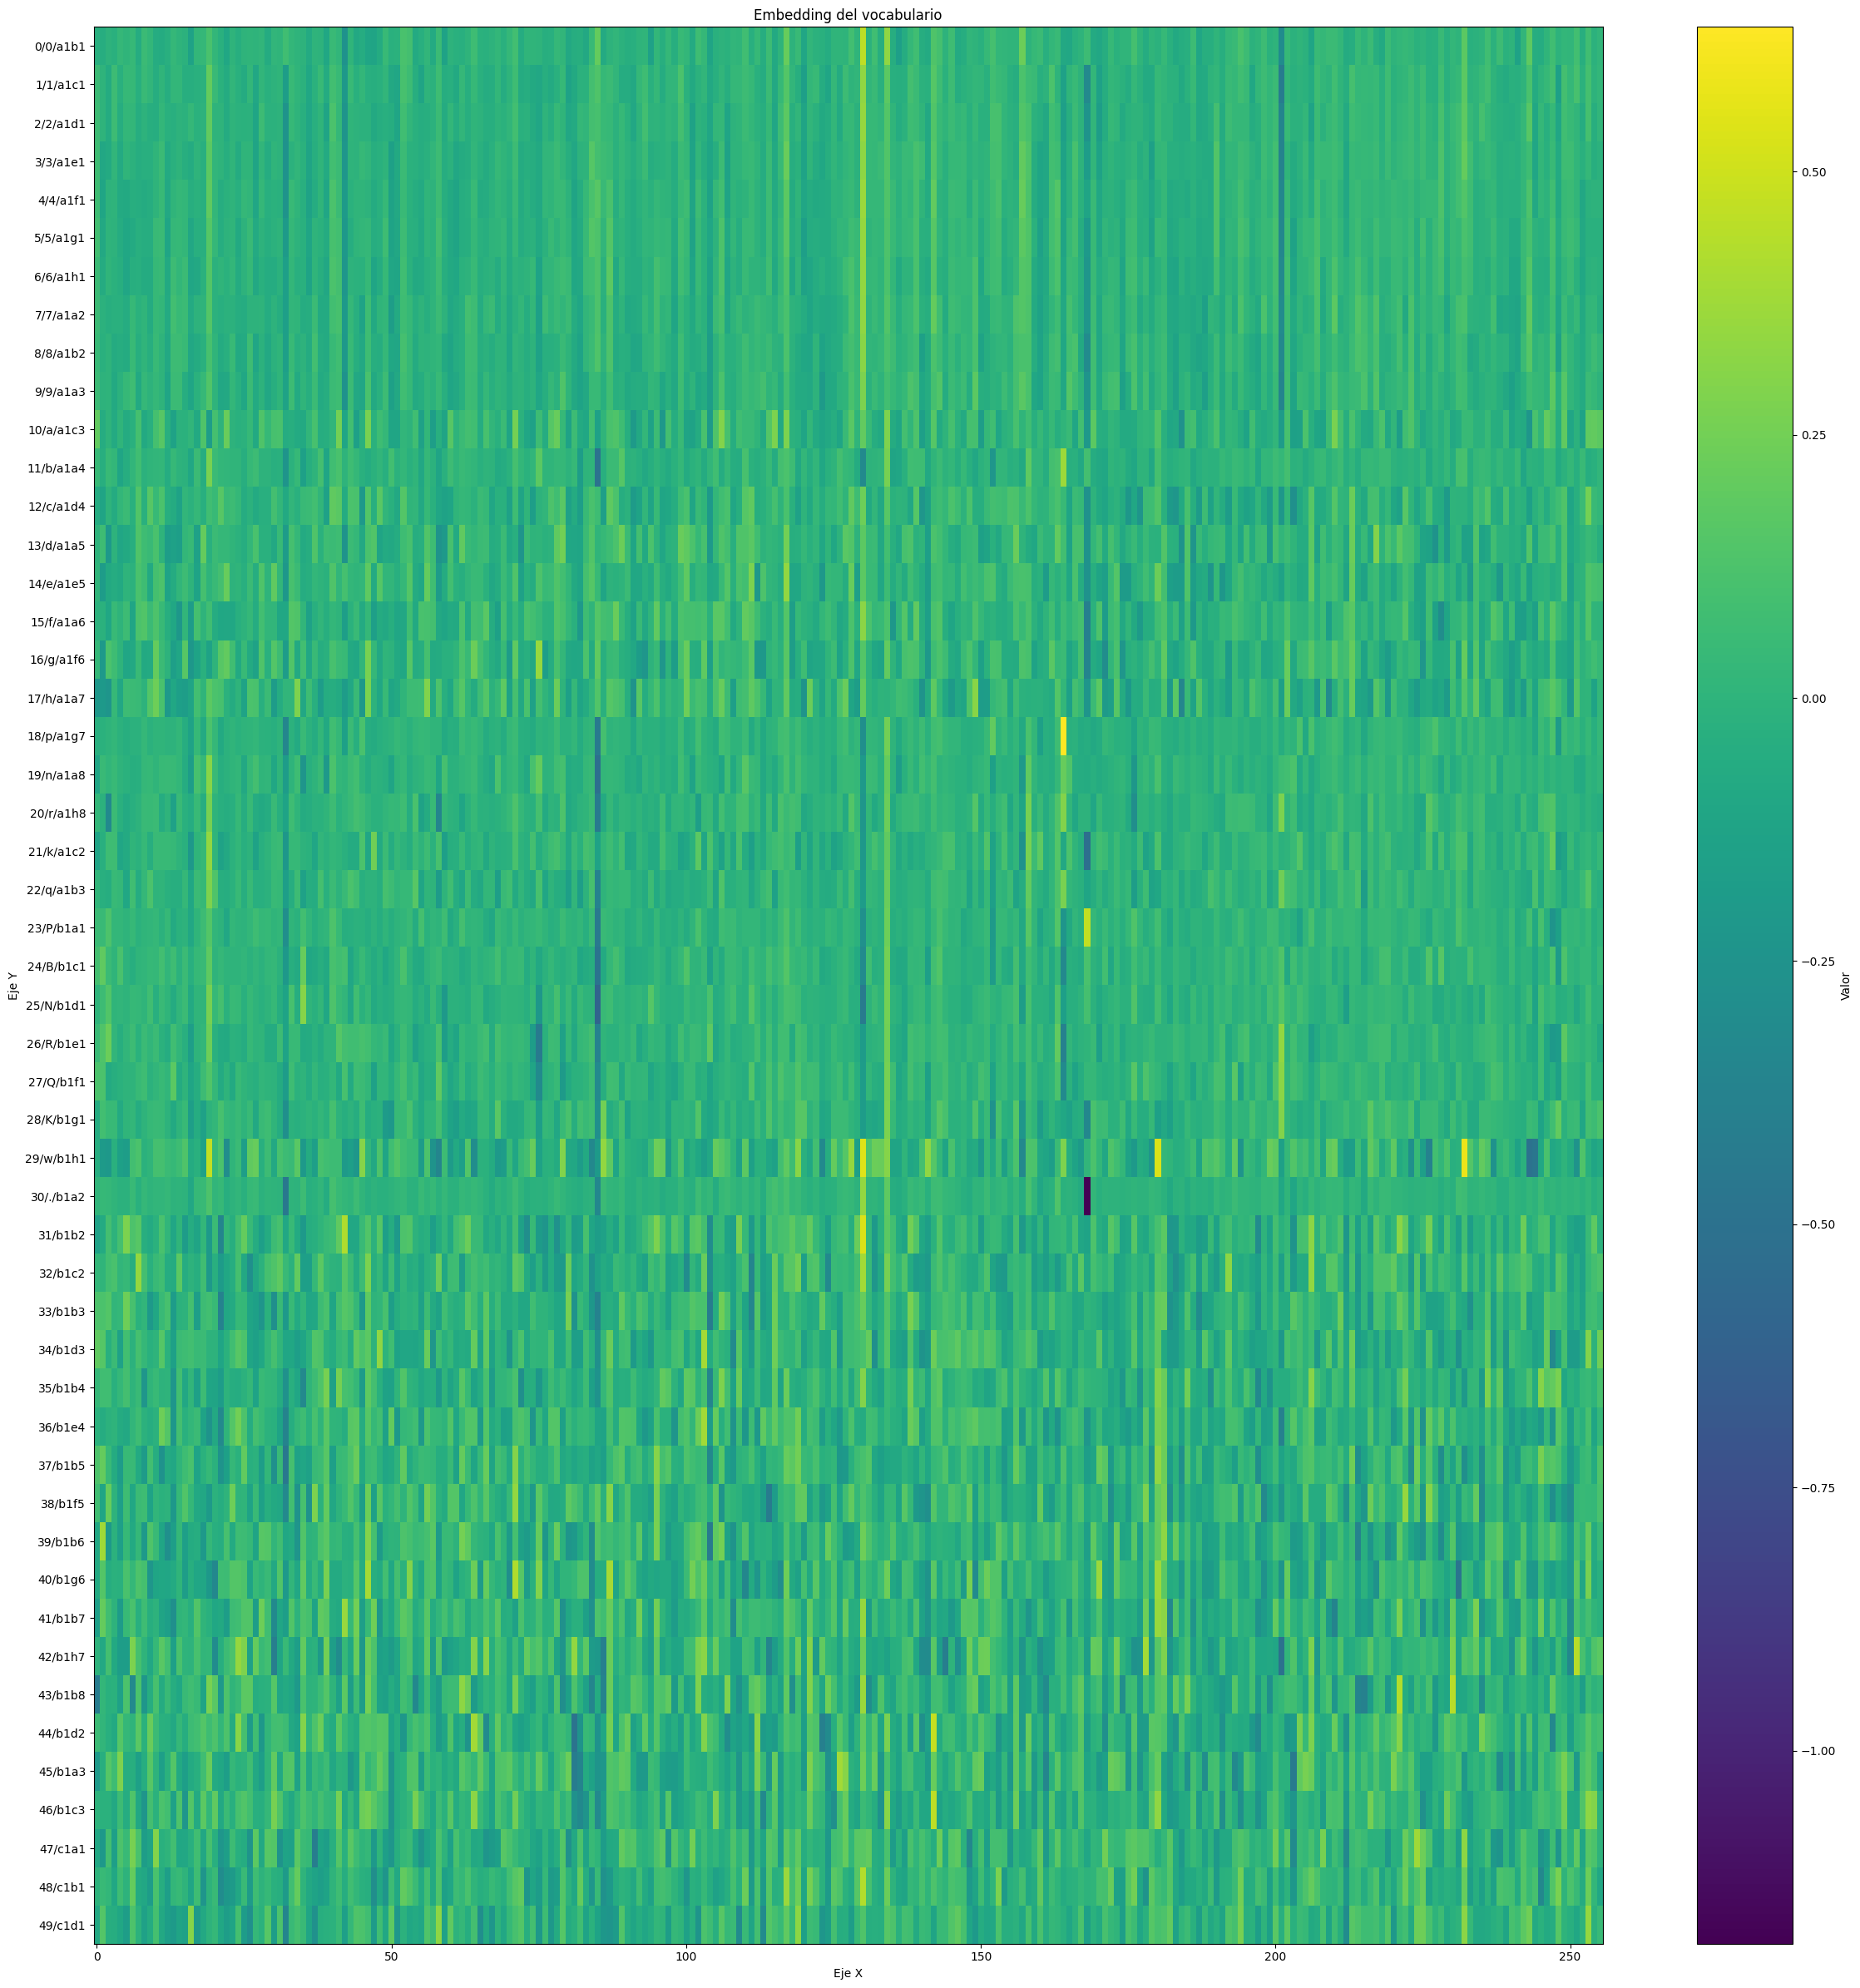

In [52]:
# Graficamos los embeddings de los tokens
num_rows = 50

plt.figure(figsize=(24, 24))
plt.imshow(params['embed']['embeddings'][:num_rows, :], aspect='auto', cmap='viridis')
plt.colorbar(label='Valor')
plt.title('Embedding del vocabulario')
plt.xlabel('Eje X')
plt.ylabel('Eje Y')

# Asignar etiquetas al eje Y
yticks = list(y_labels_dict.keys())[:num_rows]
yticklabels = list(y_labels_dict.values())[:num_rows]
plt.yticks(ticks=yticks, labels=yticklabels)

plt.tight_layout()
plt.show()

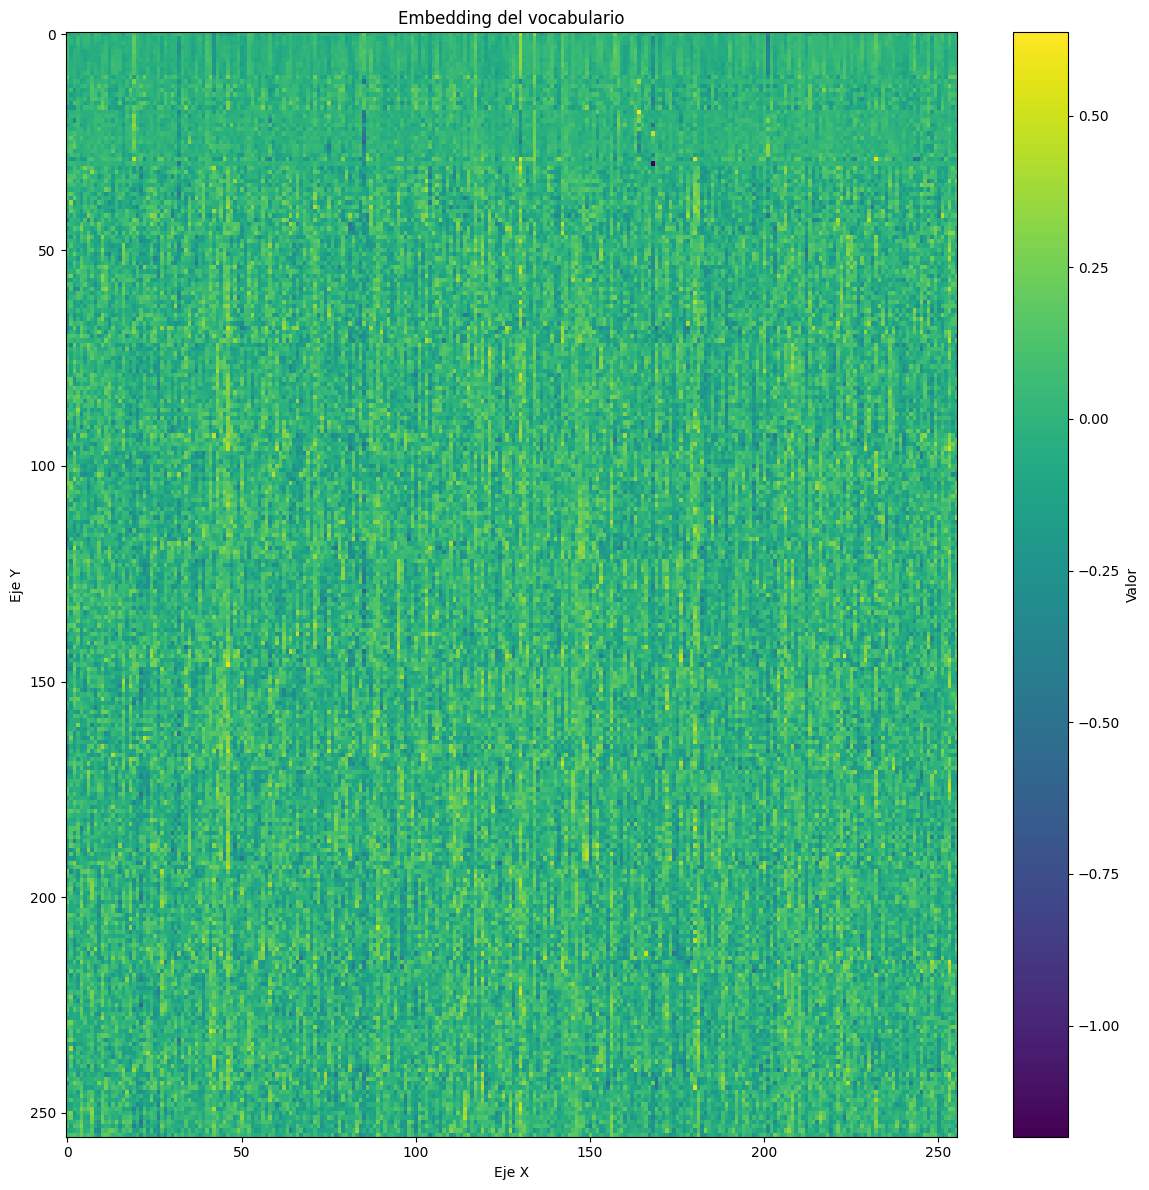

In [53]:
# Crear un array de ejemplo de tamaño 79x256
data = params['embed']['embeddings'][:256,:]

# Crear el mapa de calor
plt.figure(figsize=(12, 12))
plt.imshow(data, aspect='auto', cmap='viridis')  # Puedes usar otros cmap como 'plasma', 'hot', 'coolwarm'
plt.colorbar(label='Valor')
plt.title('Embedding del vocabulario')
plt.xlabel('Eje X')
plt.ylabel('Eje Y')
plt.tight_layout()
plt.show()

In [54]:
# IDEA: Extraer solo embeddings de piezas o posiciones y ver si tienen características en común
# En qué se diferencian los embeddings de la misma pieza según el color?

In [55]:
print(params['embed']['embeddings'].shape)

(1968, 256)


In [56]:
# Calcular la distancia entre los embeddings de cada token
"""
data = params['embed']['embeddings']
distances = np.zeros((data.shape[0], data.shape[0]))

for i in range(data.shape[0]):
    if i % 10 == 0:
        print(i)
    for j in range(i+1, data.shape[0]):
        distances[i,j] = np.linalg.norm(data[i] - data[j])
        
for i in range(data.shape[0]):
    for j in range(i+1):
        distances[i,j] = distances[j,i]
np.save('distances_between_token_embeddings.npy', distances)
"""

"\ndata = params['embed']['embeddings']\ndistances = np.zeros((data.shape[0], data.shape[0]))\n\nfor i in range(data.shape[0]):\n    if i % 10 == 0:\n        print(i)\n    for j in range(i+1, data.shape[0]):\n        distances[i,j] = np.linalg.norm(data[i] - data[j])\n        \nfor i in range(data.shape[0]):\n    for j in range(i+1):\n        distances[i,j] = distances[j,i]\nnp.save('distances_between_token_embeddings.npy', distances)\n"

In [57]:
distances = np.load('distances_between_token_embeddings.npy')
distances.shape

(1968, 1968)

[False False False ... False False False]
['11/b/a1a4', '19/n/a1a8', '20/r/a1h8', '21/k/a1c2', '22/q/a1b3', '23/P/b1a1', '24/B/b1c1', '25/N/b1d1', '26/R/b1e1', '27/Q/b1f1', '28/K/b1g1', '30/./b1a2']


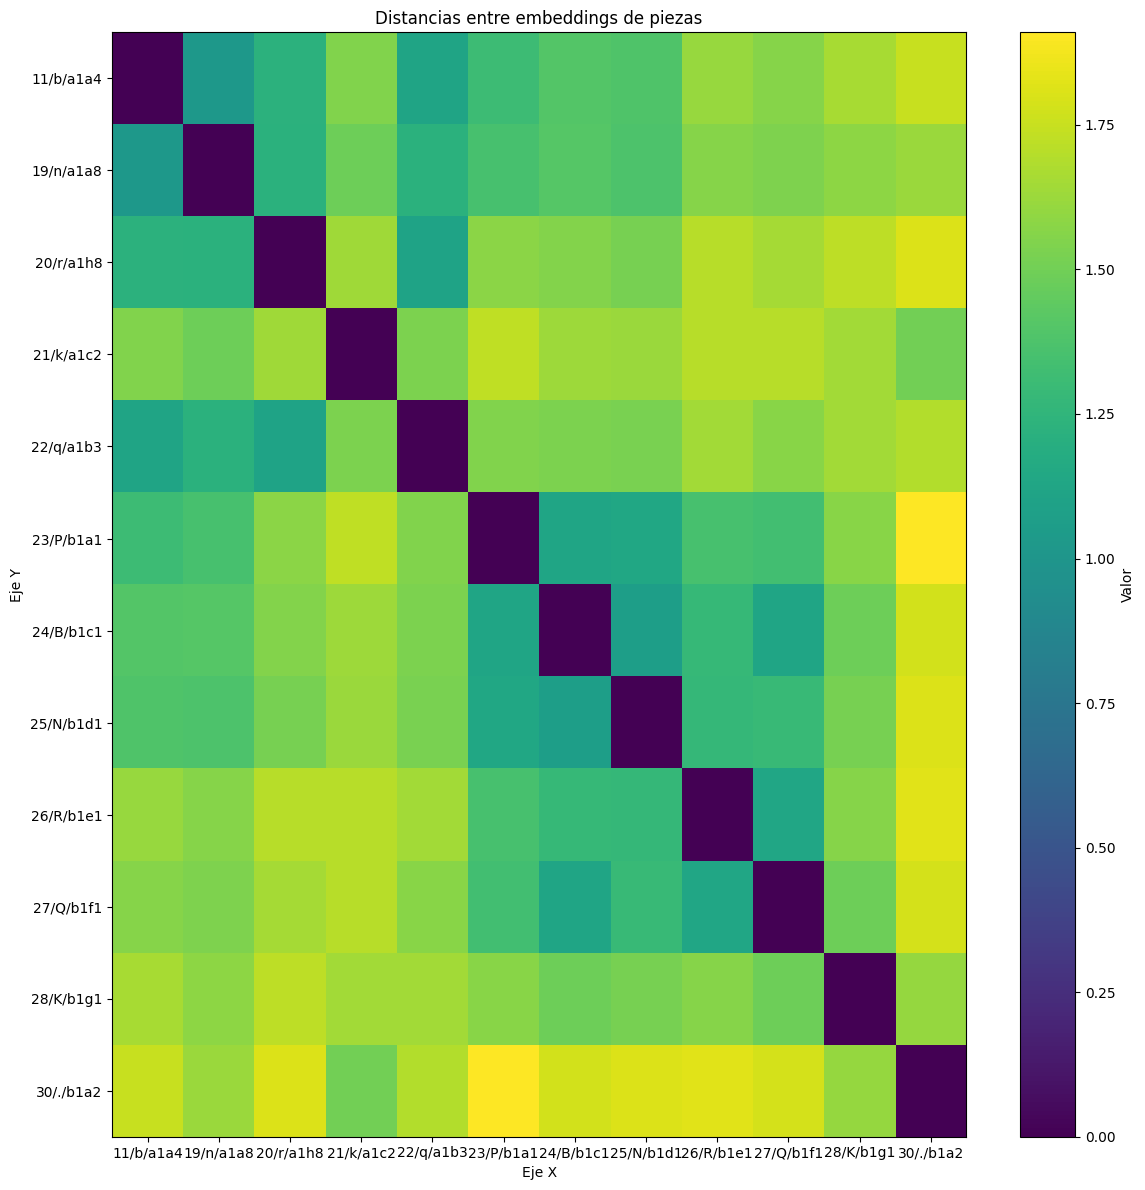

In [58]:
# Seleccionamos las posiciones donde estan las piezas
pos_b = 11
pos_ini_piezas = 19
pos_fin_piezas = 29
pos_point = 30

is_pieza = np.zeros((distances.shape[0],), dtype=bool)
is_pieza[pos_b] = 1
is_pieza[pos_ini_piezas:pos_fin_piezas] = 1
is_pieza[pos_point] = 1
print(is_pieza)

distances_piezas = distances[np.ix_(is_pieza, is_pieza)]


# Crear el mapa de calor con las distancias entre embeddings
plt.figure(figsize=(12, 12))
plt.imshow(distances_piezas, aspect='auto', cmap='viridis') 
plt.colorbar(label='Valor')
plt.title('Distancias entre embeddings de piezas')
plt.xlabel('Eje X')
plt.ylabel('Eje Y')

# Asignar etiquetas a los ejes
ticklabels = [y_labels_dict[k] for k in np.argwhere(is_pieza == 1).flatten()]
ticks = np.arange(len(ticklabels))
print(ticklabels)
plt.xticks(ticks=ticks, labels=ticklabels)
plt.yticks(ticks=ticks, labels=ticklabels)

plt.tight_layout()
plt.show()

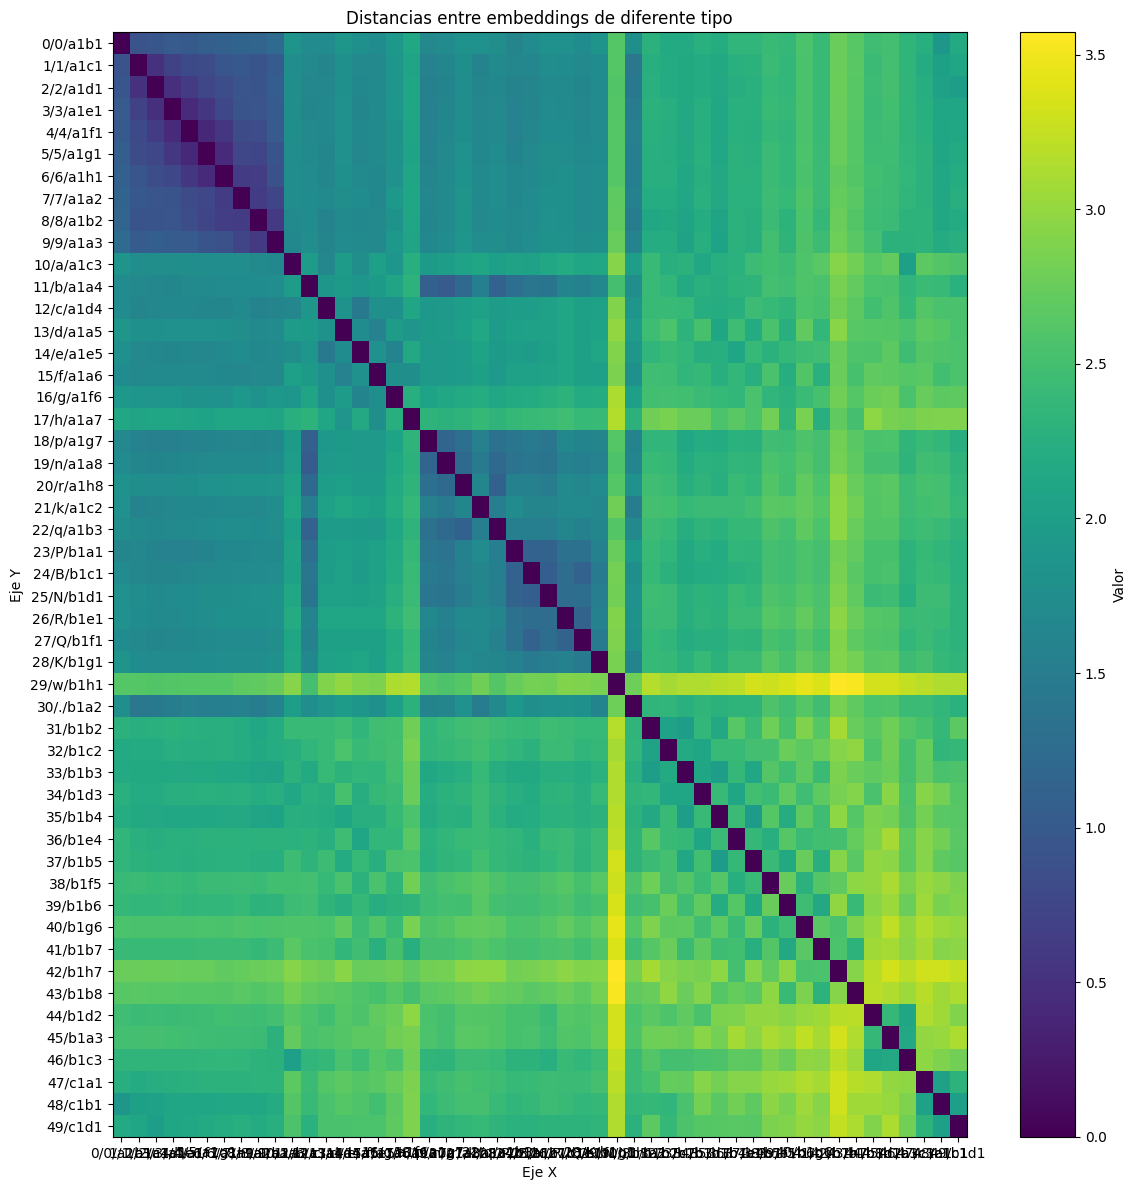

In [59]:
fila_inicial = 0
fila_final = 50
# Crear el mapa de calor con las distancias entre embeddings
plt.figure(figsize=(12, 12))
plt.imshow(distances[fila_inicial:fila_final,fila_inicial:fila_final], aspect='auto', cmap='viridis')  # Puedes usar otros cmap como 'plasma', 'hot', 'coolwarm'
plt.colorbar(label='Valor')
plt.title('Distancias entre embeddings de diferente tipo')
plt.xlabel('Eje X')
plt.ylabel('Eje Y')

# Asignar etiquetas a los ejes
ticks = list(range(fila_final-fila_inicial))
ticklabels = list(y_labels_dict.values())[fila_inicial:fila_final]
plt.xticks(ticks=ticks, labels=ticklabels)
plt.yticks(ticks=ticks, labels=ticklabels)


plt.tight_layout()
plt.show()

KeyboardInterrupt: 

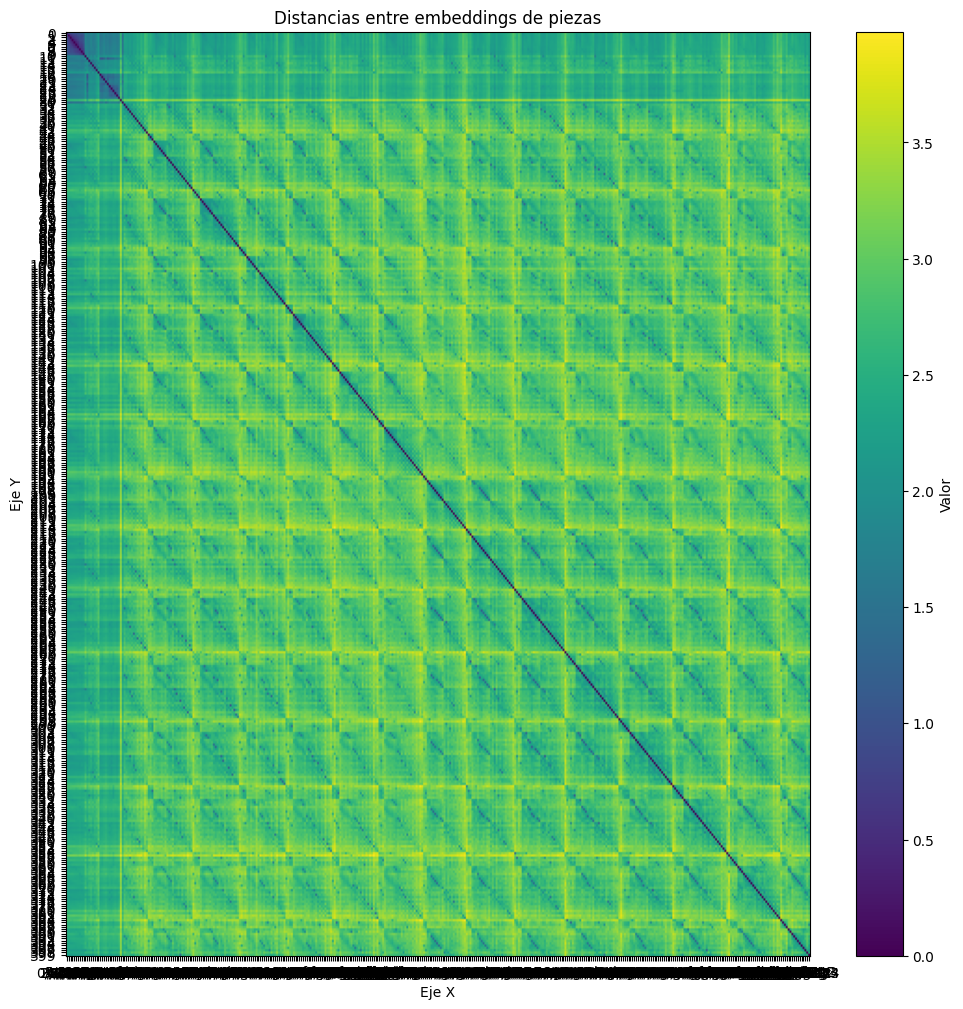

In [60]:
fila_inicial = 0
fila_final = 400
# Crear el mapa de calor con las distancias entre embeddings
plt.figure(figsize=(12, 12))
plt.imshow(distances[fila_inicial:fila_final,fila_inicial:fila_final], aspect='auto', cmap='viridis')  # Puedes usar otros cmap como 'plasma', 'hot', 'coolwarm'
plt.colorbar(label='Valor')
plt.title('Distancias entre embeddings de piezas')
plt.xlabel('Eje X')
plt.ylabel('Eje Y')

# Asignar etiquetas a los ejes
ticks = list(range(fila_final-fila_inicial))
ticklabels = list(y_labels_dict.values())[fila_inicial:fila_final]
plt.xticks(ticks=ticks, labels=ticklabels)
plt.yticks(ticks=ticks, labels=ticklabels)


plt.tight_layout()
plt.show()

In [ ]:
fila_inicial = 0
fila_final = 400
# Crear el mapa de calor con las distancias entre embeddings
plt.figure(figsize=(12, 12))
plt.imshow(distances[fila_inicial:fila_final,fila_inicial:fila_final], aspect='auto', cmap='viridis')  # Puedes usar otros cmap como 'plasma', 'hot', 'coolwarm'
plt.colorbar(label='Valor')
plt.title('Distancias entre embeddings de piezas')
plt.xlabel('Eje X')
plt.ylabel('Eje Y')

# Asignar etiquetas a los ejes
ticks = list(range(fila_final-fila_inicial))
ticklabels = list(y_labels_dict.values())[fila_inicial:fila_final]
plt.xticks(ticks=ticks, labels=ticklabels)
plt.yticks(ticks=ticks, labels=ticklabels)


plt.tight_layout()
plt.show()

In [ ]:
# Crear el mapa de calor con las distancias entre embeddings
plt.figure(figsize=(30, 30))
plt.imshow(distances, aspect='auto', cmap='viridis')  # Puedes usar otros cmap como 'plasma', 'hot', 'coolwarm'
plt.colorbar(label='Valor')
plt.title('Distancias entre embeddings de piezas')
plt.xlabel('Eje X')
plt.ylabel('Eje Y')

# Asignar etiquetas a los ejes
ticks = np.arange(len(distances))
ticklabels = list(y_labels_dict.values())
plt.xticks(ticks=ticks, labels=ticklabels)
plt.yticks(ticks=ticks, labels=ticklabels)


plt.tight_layout()
plt.show()

In [ ]:
fila_inicial = 0
fila_final = 100
# Crear el mapa de calor con las distancias entre embeddings
plt.figure(figsize=(12, 12))
plt.imshow(distances[fila_inicial:fila_final,fila_inicial:fila_final], aspect='auto', cmap='viridis')  # Puedes usar otros cmap como 'plasma', 'hot', 'coolwarm'
plt.colorbar(label='Valor')
plt.title('Distancias entre embeddings de piezas')
plt.xlabel('Eje X')
plt.ylabel('Eje Y')

# Asignar etiquetas a los ejes
ticks = list(range(fila_final-fila_inicial))
ticklabels = list(y_labels_dict.values())[fila_inicial:fila_final]
plt.xticks(ticks=ticks, labels=ticklabels)
plt.yticks(ticks=ticks, labels=ticklabels)


plt.tight_layout()
plt.show()

In [ ]:
"""
# Obtenemos los logits y graficamos los mapas de atención
for result, move in zip(results, engine.get_ordered_legal_moves(board)):
    print('Jugada:', move)
    logits, attention_maps = result
    print('logits:', logits.shape)
    print('logits:', logits)
    plot_attention_maps(attention_maps, token_labels=token_labels, save_path=f'xai/experiment1/79x79/attention_maps_{move}.png')
"""

In [ ]:
"""
# Obtenemos los logits y graficamos los mapas de atención
os.makedirs(f'xai/experiment1/reordered_by_row', exist_ok=True)
os.makedirs(f'xai/experiment1/reordered_by_col', exist_ok=True)
for result, move in zip(results, engine.get_ordered_legal_moves(board)):
    for by_row in [True, False]:
        print('Jugada:', move)
        logits, attention_maps = result
        attention_maps = np.array(attention_maps).reshape(num_layers, num_heads, 79, 79)
        #print('logits:', logits.shape)
        print('logits:', logits)
        plot_all_attention_heads(attention_maps, token_labels=token_labels, by_row=by_row,
                            save_path=f'xai/experiment1/reordered_{"by_row" if by_row else "by_col"}/attention_maps_{move}.png')
"""

In [ ]:
# Guardamos los resultados en disco
"""
with open('xai/experiment1/results.pkl', 'wb') as f:
    pickle.dump(results, f)
"""

# Atención

## Pesos de atención

In [ ]:
token_labels = ['<start>', '<turn>',
                'a8', 'b8', 'c8', 'd8', 'e8', 'f8', 'g8', 'h8',
                'a7', 'b7', 'c7', 'd7', 'e7', 'f7', 'g7', 'h7',
                'a6', 'b6', 'c6', 'd6', 'e6', 'f6', 'g6', 'h6',
                'a5', 'b5', 'c5', 'd5', 'e5', 'f5', 'g5', 'h5',
                'a4', 'b4', 'c4', 'd4', 'e4', 'f4', 'g4', 'h4',
                'a3', 'b3', 'c3', 'd3', 'e3', 'f3', 'g3', 'h3',
                'a2', 'b2', 'c2', 'd2', 'e2', 'f2', 'g2', 'h2',
                'a1', 'b1', 'c1', 'd1', 'e1', 'f1', 'g1', 'h1',
                '<castling_1>', '<castling_2>', '<castling_3>', '<castling_4>',
                '<en_passant_letter>','<en_passant_number>',
                '<halfmove_1>', '<halfmove_2>', '<halfmove_3>',
                '<fullmove_1>', '<fullmove_2>', '<fullmove_3>', 
                'move']
token_labels = np.array(token_labels)

In [ ]:
def get_sequences_from_board(board: chess.Board) -> np.ndarray:
    """Get the sequences from a chess board."""
    sorted_legal_moves = engine.get_ordered_legal_moves(board)
    #print('sorted_legal_moves:', sorted_legal_moves)
    legal_actions = [utils.MOVE_TO_ACTION[x.uci()] for x in sorted_legal_moves]
    #print('legal_actions 1:', legal_actions)
    legal_actions = np.array(legal_actions, dtype=np.int32)
    #print('legal_actions 2:', legal_actions)
    legal_actions = np.expand_dims(legal_actions, axis=-1)
    #print('legal_actions 3:', legal_actions)
    #print('legal_actions.shape:', legal_actions.shape)
    # Tokenize the return buckets.
    dummy_return_buckets = np.zeros((len(legal_actions), 1), dtype=np.int32)
    #print('dummy_return_buckets:', dummy_return_buckets)
    #print('dummy_return_buckets.shape:', dummy_return_buckets.shape)
    # Tokenize the board.
    tokenized_fen = tokenizer.tokenize(board.fen()).astype(np.int32)
    #print('tokenized_fen:', tokenized_fen)
    #print('tokenized_fen.shape:', tokenized_fen.shape)
    sequences = np.stack([tokenized_fen] * len(legal_actions))
    #print('sequences:', sequences)
    #print('sequences.shape:', sequences.shape)
    # Create the sequences.
    sequences = np.concatenate(
        [sequences, legal_actions, dummy_return_buckets],
        axis=1,
    )
    return sequences

In [ ]:
def plot_attention_maps(attention_maps, token_labels=None, save_path=None):
    """
    attention_maps: List of jax arrays [B, H, T, T], one per layer.
    token_labels: Optional list of labels for tokens.
    """
    num_layers, num_heads, seq_len, _ = attention_maps.shape

    fig, axs = plt.subplots(num_layers, num_heads, figsize=(num_heads*8, num_layers*8))

    for l, layer_attn in enumerate(attention_maps):
        for h in range(num_heads):
            ax = axs[l, h] if num_layers > 1 else axs[h]
            attn = np.array(layer_attn[h])  # (T, T)
            im = ax.imshow(attn, cmap="viridis")
            ax.set_title(f"L{l+1}H{h+1}", fontsize=8)
            if token_labels is not None:
                ax.set_xticks(range(seq_len))
                ax.set_yticks(range(seq_len))
                ax.set_xticklabels(token_labels, rotation=90)
                ax.set_yticklabels(token_labels)
            else:
                ax.set_xticks([])
                ax.set_yticks([])

    fig.tight_layout()
    if save_path:
        plt.savefig(save_path)
        plt.close(fig)
    else:
        plt.show()

In [ ]:
def plot_attention_in_board(attention_map, by_row = True, token_labels=None, save_path=None):
    """
    attention_maps: List of jax arrays [B, H, T, T], one per layer.
    token_labels: Optional list of labels for tokens.
    """
    fig, axes = plt.subplots(nrows=10, ncols=8, figsize=(16, 20))
    axes = axes.flatten()  # Para iterar fácilmente
    
    padded_attention_map = np.pad(attention_map, ((0, 1), (0, 1)), mode='constant', constant_values=0)
    
    ordered_indices = np.arange(2, 66)
    ordered_indices = np.concatenate((ordered_indices, [0, 1]))
    ordered_indices = np.concatenate((ordered_indices, np.arange(66, 79)))
    ordered_indices_padded = np.concatenate((ordered_indices, [79]))
    
    # Dibujar cada fila como heatmap en su subplot correspondiente
    for i,j in zip(ordered_indices, range(79)): 
        ax = axes[j]
        if by_row:
            row_data = padded_attention_map[i,ordered_indices_padded].reshape(-1, 8)  # Mantenerlo 2D
        else:
            row_data = padded_attention_map[ordered_indices_padded,i].reshape(-1, 8)
        im = ax.imshow(row_data, aspect='auto', cmap='viridis')
        if j < 64:
            ax.set_title(token_labels[i-1])
        else:
            ax.set_title(token_labels[i])
        
        if j % 8 == 0:  # Primera columna
            ax.set_yticks(range(10))
            ax.set_yticklabels(token_labels[ordered_indices][::8])
        else:
            ax.set_yticks([])
        ax.set_xticks([])
        ax.set_xticklabels([])
        #ax.set_yticklabels(token_labels[ordered_indices].astype(int)[::8])
            
        #ax.axis('off')
    
    # Ocultar el subplot sobrante (posición 80)
    axes[79].axis('off')

    # Agregar barra de color a la derecha de todos los subgráficos
    
    plt.tight_layout()
    #fig.colorbar(im, ax=axes.tolist(), shrink=0.6)
    if save_path:
        plt.savefig(save_path)
        plt.close(fig)
    else:
        plt.show()

In [ ]:
def plot_attention_in_board_embedded(attention_map, token_labels, fig, subplot_spec, by_row=True, vmin=None, vmax=None):
    """
    attention_map: numpy array [79, 79]
    token_labels: list of token strings
    fig: Matplotlib figure
    subplot_spec: GridSpec SubplotSpec to draw the board into
    use_divergent_cmap: bool - whether to use a divergent colormap centered at 0
    """
    gs = gridspec.GridSpecFromSubplotSpec(10, 8, subplot_spec=subplot_spec, wspace=0.5, hspace=0.5)
    padded_attention_map = np.pad(attention_map, ((0, 1), (0, 1)), mode='constant', constant_values=0)
    ordered_indices = np.concatenate([np.arange(2, 66), [0, 1], np.arange(66, 79)])
    ordered_indices_padded = np.concatenate([ordered_indices, [79]])

    ordered_token_labels = token_labels[ordered_indices]

    for idx, i in enumerate(ordered_indices):
        row = idx // 8
        col = idx % 8
        ax = fig.add_subplot(gs[row, col])
        if by_row:
            data = padded_attention_map[i, ordered_indices_padded].reshape(-1, 8)
        else:
            data = padded_attention_map[ordered_indices_padded, i].reshape(-1, 8)

        if vmin is not None and vmax is not None:
            im = ax.imshow(data, aspect='auto', cmap='seismic', vmin=vmin, vmax=vmax)
        else:
            im = ax.imshow(data, aspect='auto', cmap='viridis')

        ax.set_title(ordered_token_labels[idx], fontsize=6)
        ax.set_xticks([])
        ax.set_yticks([])

    fig.add_subplot(gs[-1, -1]).axis('off')  # Oculta el subplot extra

def plot_all_attention_heads(attention_maps, token_labels, by_row=True, save_path=None, scale_in_1=True):
    """
    attention_maps: numpy array of shape (4, 4, 79, 79)
    token_labels: list of token strings
    use_divergent_cmap: bool - whether to use a divergent colormap for all heatmaps
    """
    num_layers, num_heads, _, _ = attention_maps.shape
    fig = plt.figure(figsize=(num_heads * 10, num_layers * 10))
    outer = gridspec.GridSpec(num_layers, num_heads, wspace=0.1, hspace=0.1)

    for l in range(num_layers):
        for h in range(num_heads):
            attention_map = attention_maps[l, h]
            subplot_spec = outer[l, h]
            if scale_in_1:
                plot_attention_in_board_embedded(
                    attention_map,
                    token_labels,
                    fig,
                    subplot_spec,
                    by_row=by_row,
                    vmin=-1,
                    vmax=1
                )
            else:
                plot_attention_in_board_embedded(
                    attention_map,
                    token_labels,
                    fig,
                    subplot_spec,
                    by_row=by_row
                )
            ax = fig.add_subplot(subplot_spec)
            ax.set_title(f"Capa {l+1}, Cabeza {h+1}", fontsize=10)
            ax.axis('off')

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path)
        plt.close(fig)
    else:
        plt.show()


Prueba:

In [ ]:
board = chess.Board()
sequences = get_sequences_from_board(board)
print(sequences.shape)
results = predict_fn(sequences)
logits, attention_maps = results[0]
attention_maps = np.array(attention_maps).reshape(num_layers, num_heads, 79, 79)
print('results:', logits.shape)
print('attention_maps_shape:', attention_maps.shape)
plot_attention_maps(attention_maps, token_labels=token_labels)
plot_all_attention_heads(attention_maps, token_labels=token_labels)

## Attention Rollout

In [ ]:
def attention_rollout(attention_maps, alpha=0.5):
    """
    attention_maps: numpy array of shape (num_layers, num_heads, seq_len, seq_len)
    alpha: float - smoothing factor
    """
    num_layers, num_heads, seq_len, _ = attention_maps.shape
    
    # Calculamos los mapas de atención medios por capa
    aggregated_attention = np.zeros((num_layers, seq_len, seq_len))
    for l in range(num_layers):
        aggregated_attention[l] = np.mean(attention_maps[l], axis=0)  # Media entre cabezas de atención
    
    # Añadimos la influencia de las capas residuales
    for l in range(1, num_layers):
        aggregated_attention[l] = aggregated_attention[l] * alpha + np.diag(np.ones(seq_len)) * (1 - alpha) 
        
    # Calculamos el atention rollout de las capas
    attention_rollout = np.zeros((num_layers, seq_len, seq_len))

    attention_rollout[0] = aggregated_attention[0]
    for l in range(1,num_layers):
        attention_rollout[l] = aggregated_attention[l] @ attention_rollout[l-1]

    return attention_rollout

In [ ]:
board = chess.Board('1k6/8/8/8/8/8/7P/1K6 w - - 0 1')
sequences = get_sequences_from_board(board)
print(sequences.shape)
results = predict_fn(sequences)
logits, attention_maps = results[0]
attention_maps = np.array(attention_maps).reshape(num_layers, num_heads, 79, 79)
print('results:', logits.shape)
print('attention_maps_shape:', attention_maps.shape)

(7, 79)
results: (1, 79, 128)
attention_maps_shape: (8, 8, 79, 79)


/tmp/ipykernel_1991191/3221414511.py:72: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


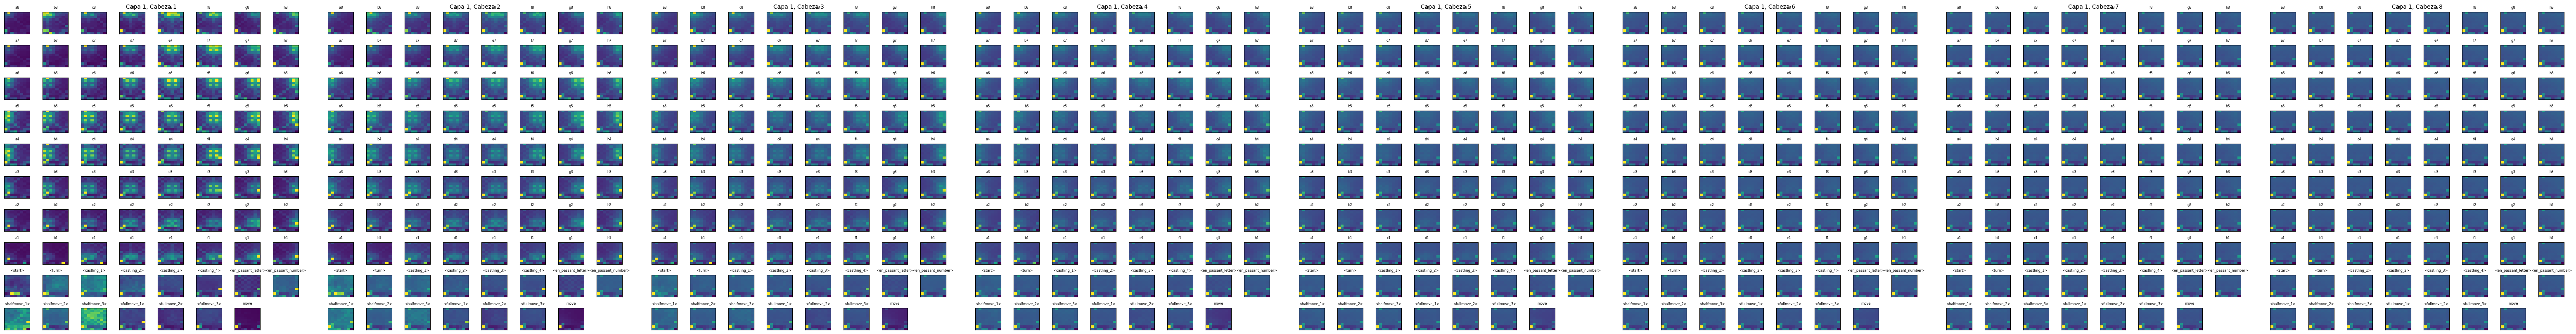

In [ ]:
attention_rollout_maps = attention_rollout(attention_maps, alpha=0.5)

plot_all_attention_heads(attention_rollout_maps.reshape(1,-1,79,79), token_labels=token_labels, scale_in_1=False)

## Attention flow

In [68]:
def get_attention_graph(attention_maps, alpha = 0.5):
    mat = attention_maps.mean(axis=1)
    n_layers, length, _ = mat.shape
    G = nx.DiGraph()

    for i in range(1, n_layers + 1):
        for k_f in range(length):
            index_from = (i,k_f)
            for k_t in range(length):
                index_to = (i - 1, k_t)
                weight = mat[i - 1][k_f][k_t]
                weight += 0.5 if k_f == k_t else 0
                if weight != 0:
                    G.add_edge(index_from, index_to, capacity=weight)

    return G        

In [69]:
"""
# Implementación original de attention_flow (ineficiente - O(n^4*d^2) - n = seq_len, d = embedding_dim
def compute_flows(attention_maps):
    n_layers, _, length, _ = attention_maps.shape
    G = get_attention_graph(attention_maps)
    
    flow_values=np.zeros((length, length))
    for i in range(length):
        u = (n_layers, i)
        for j in range(length):
            v = (0, j)
            try:
                flow, _  = nx.maximum_flow(G, u, v)
            except nx.NetworkXUnfeasible:
                flow = 0.0  # si no hay camino posible
            flow_values[i, j] = flow
    
    # Normalización fila por fila (por nodo de salida)
    row_sums = flow_values.sum(axis=1, keepdims=True)
    row_sums[row_sums == 0] = 1  # evita división por cero
    flow_values /= row_sums
    
    return flow_values
"""

'\n# Implementación original de attention_flow (ineficiente - O(n^4*d^2) - n = seq_len, d = embedding_dim\ndef compute_flows(attention_maps):\n    n_layers, _, length, _ = attention_maps.shape\n    G = get_attention_graph(attention_maps)\n    \n    flow_values=np.zeros((length, length))\n    for i in range(length):\n        u = (n_layers, i)\n        for j in range(length):\n            v = (0, j)\n            try:\n                flow, _  = nx.maximum_flow(G, u, v)\n            except nx.NetworkXUnfeasible:\n                flow = 0.0  # si no hay camino posible\n            flow_values[i, j] = flow\n    \n    # Normalización fila por fila (por nodo de salida)\n    row_sums = flow_values.sum(axis=1, keepdims=True)\n    row_sums[row_sums == 0] = 1  # evita división por cero\n    flow_values /= row_sums\n    \n    return flow_values\n'

In [70]:
def compute_attention_flow(attn_weights: np.ndarray, sink_token, source_layer = None) -> np.ndarray:
    """
    Calcula el flujo máximo de atención desde todos los token de salida 
    hacia el token de entrada sink_token a través del grafo de atención.
    
    Parámetros:
        attn_weights: np.ndarray con forma (num_layers, num_heads, seq_len, seq_len)
                      Representa atención desde tokens de capa l-1 a tokens de capa l.
        source_token: índice del token en la capa final desde donde fluye la atención (e.g., [CLS]=0)
    
    Retorna:
        flow_to_inputs: np.ndarray con forma (seq_len,)
                        Cantidad de atención que fluye desde el token origen a cada token de entrada.
    """
    
    num_layers, _, seq_len, _ = attn_weights.shape
    if source_layer is None:
        source_layer = num_layers
    G = get_attention_graph(attn_weights)

    sink = (0, sink_token)
    supersource = "supersource"
    for t in range(seq_len):
        G.add_edge(supersource, (source_layer, t), capacity=float('inf'))
    
    flow_value = nx.maximum_flow_value(G, supersource, sink)
    
    return flow_value


In [76]:

def plot_attention_flow(attention_flow_vals, token_labels):
    """
    Plotea el flujo de atención como un heatmap con las etiquetas de tokens dentro de cada celda.
    
    Parámetros:
        attention_flow_vals: np.ndarray de forma (seq_len,)
                             Valores de flujo de atención por token.
        token_labels: np.ndarray o lista de strings de longitud seq_len
                      Etiquetas de los tokens.
    """
    # Padding para completar 80 posiciones
    padded_attention_map = np.concatenate((attention_flow_vals, [0]), axis=0)
    ordered_indices = np.concatenate([np.arange(2, 66), [0, 1], np.arange(66, 79)])
    ordered_indices_padded = np.concatenate([ordered_indices, [79]])
    
    # Reordenar etiquetas
    ordered_token_labels = np.array(token_labels)[ordered_indices]

    # Preparar datos en forma de matriz (10x8)
    data = padded_attention_map[ordered_indices_padded].reshape(-1, 8)

    plt.figure(figsize=(12, 10))
    im = plt.imshow(data, aspect='auto', cmap='viridis')

    # Añadir las etiquetas dentro de las celdas
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            idx = i * 8 + j
            if idx < len(ordered_token_labels):
                plt.text(j, i, ordered_token_labels[idx], 
                         ha='center', va='center', fontsize=7, color='white')

    plt.xticks([])
    plt.yticks([])
    plt.colorbar(im, label='Attention Flow Value')
    plt.title("Attention Flow Heatmap", fontsize=14)
    plt.tight_layout()
    plt.show()

In [72]:
attention_flow_vals = np.zeros((79,))
for i in range(79):
    if i % 10 == 0:
        print(i)
    attention_flow_vals[i] = compute_attention_flow(attention_maps, sink_token=i)

0


10
20
30
40
50
60
70


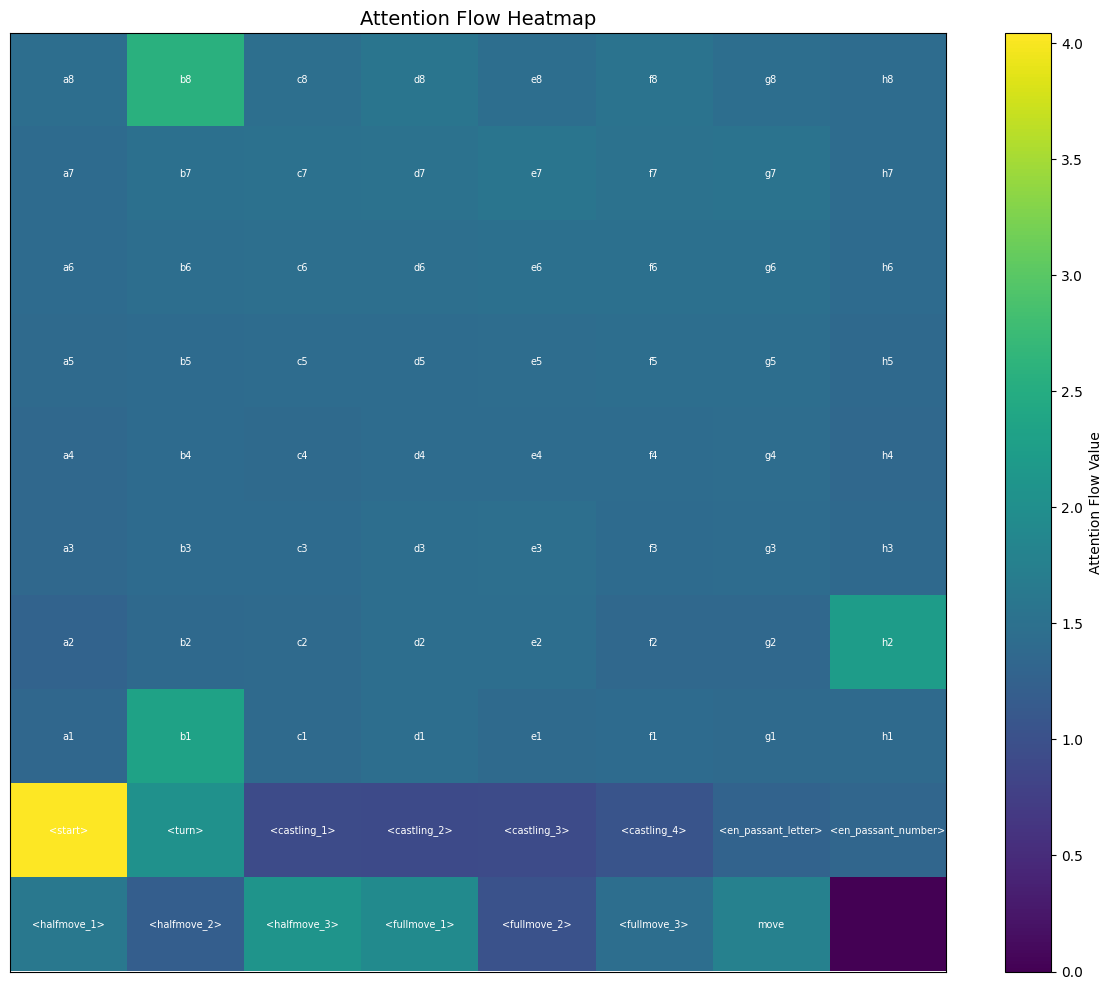

In [77]:
plot_attention_flow(attention_flow_vals, token_labels=token_labels)

# Gradientes de las entradas

In [ ]:
def compute_token_grad_importance(
    predictor,      # constants.Predictor
    params,         # parámetros cargados
    input_seq,      # np.array shape (1, T) con índices de tokens
    config          # TransformerConfig
):
    """
    Calcula la relevancia (gradientes) de cada token de entrada usando override_embedding.

    Returns:
      importances: np.array shape (T,) con la derivada del log-prob del token objetivo.
    """
    # Dimensiones
    T = input_seq.shape[0]
    V = config.vocab_size

    # 1) Extrae la matriz de embeddings de params
    tok_emb_matrix = params['embed']['embeddings']
    pos_emb_matrix = params['embed_1']['embeddings']

    # 2) Construye un one-hot “suave” de tu secuencia
    inputs_shifted = transformer_xai.shift_right(input_seq.reshape(1,-1))  # shape (1, T)
    one_hot = jax.nn.one_hot(inputs_shifted, V)  # (1, T, V)

    # 3) Define la función de pérdida sobre el one-hot continuo
    def loss_fn(one_hot_cont):
        # 1) Proyección one-hot → embeddings
        token_emb = jnp.einsum('b t v, v d -> b t d', one_hot_cont, tok_emb_matrix)
        pos_emb = jnp.broadcast_to(pos_emb_matrix[None, :, :], token_emb.shape)
        final_emb = token_emb + pos_emb
        
        # 2) Inferencia override
        buckets_logp, _ = predictor.predict(
            params=params,
            targets=final_emb,
            rng=None,
            override_embedding=True,
            config=config,
        )
        # buckets_logp: (1, T, V)
        last_logp = buckets_logp[0, -1, :]        # (V,)

        _, return_buckets_values = utils.get_uniform_buckets_edges_values(
            config.output_size
        )
        
        # 3) convierte a probabilidades y calcula probabilidad de victoria
        probs = jnp.exp(last_logp)                # (V,)
        win_prob = jnp.dot(probs, return_buckets_values)  # escalar ()

        # Queremos maximizar win_prob, así que la "pérdida" la tomamos como -win_prob
        return -win_prob


    # 4) Gradiente del escalar respecto al one-hot continuo
    grad_fn = jax.grad(loss_fn)
    grads = grad_fn(one_hot)               # (1, T, V)
    jacc_fn = jax.grad(lambda x: jax.grad(loss_fn)(x).sum())
    jacc = jacc_fn(one_hot)                # (1, T, V)
    # 5) Para cada posición t, tomamos la componente del token real
    
    gradients = grads[0, jnp.arange(T), input_seq]  # (T,)
    jacobians = jacc[0, jnp.arange(T), input_seq]  # (T,)

    return np.array(gradients), np.array(jacobians)

In [ ]:
# @title Plot the attention maps
# Supón que ya has calculado:
# importances: numpy array de shape (T,) con la relevancia de cada token
# feature_names: lista de strings de longitud T con nombres legibles de cada token

def bar_plot_token_importances(importances: np.ndarray, token_labels: list[str],
                           save_path: str = None):
    """
    Grafica un bar chart mostrando la importancia de cada token.
    - importances: array de shape (T,) con relevancias.
    - feature_names: lista de longitud T con etiquetas para cada token.
    """
    T = len(importances)
    plt.figure(figsize=(12, 4))
    plt.bar(range(T), importances)
    plt.xticks(range(T), token_labels, rotation=90)
    plt.xlabel("Token")
    plt.ylabel("Importancia (gradiente)")
    plt.title("Importancia de cada token en la predicción")
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path)
        plt.close()
    else:
        plt.show()

def board_plot_token_importances(
    importances: np.ndarray,
    token_labels: list[str],
    save_path: str = None,
):
    """
    Grafica un mapa de calor mostrando la importancia de cada token.
    - importances: array de shape (T,) con relevancias.
    - feature_names: lista de longitud T con etiquetas para cada token.
    """
    padded_importances = np.concatenate((importances, [0]))
    ordered_indices = np.concatenate([np.arange(2, 66), [0, 1], np.arange(66, 79)])
    ordered_indices_padded = np.concatenate([ordered_indices, [79]])
    padded_token_labels = np.concatenate([token_labels, ['pad']])
    ordered_token_labels = padded_token_labels[ordered_indices_padded].reshape(-1, 8)
    boarded_importances = padded_importances[ordered_indices_padded].reshape(-1, 8)
    
    plt.figure(figsize=(8, 10))
    vmin, vmax = -np.max(np.abs(importances)), np.max(np.abs(importances))

    norm = colors.TwoSlopeNorm(vmin=vmin, vcenter=0.0, vmax=vmax)

    
    im = plt.imshow(boarded_importances, aspect='auto', cmap='coolwarm', norm=norm)
    plt.title("Importancia de cada token en la predicción")
    """
    plt.xticks(range(8), ordered_token_labels[:8], rotation=90)
    plt.yticks(range(10), ordered_token_labels[::8])
    """
    for i in range(10):
        for j in range(8):
            label = ordered_token_labels[i, j]
            plt.text(j, i, label, ha='center', va='center', color='white', fontsize=7)

    plt.colorbar(label='Importancia')

    if save_path:
        plt.savefig(save_path)
        plt.close()
    else:
        plt.show()

Prueba:

In [ ]:
board = chess.Board()
sequences = get_sequences_from_board(board)
input_seq = sequences[0]

In [ ]:
gradients, jacobians = compute_token_grad_importance(
    predictor,     
    params,        
    input_seq,     
    predictor_config     
)

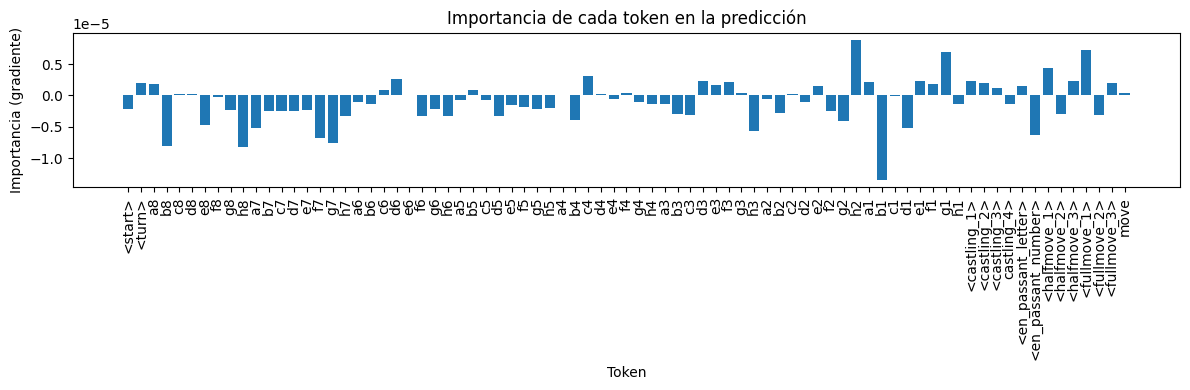

In [ ]:
bar_plot_token_importances(gradients, token_labels)

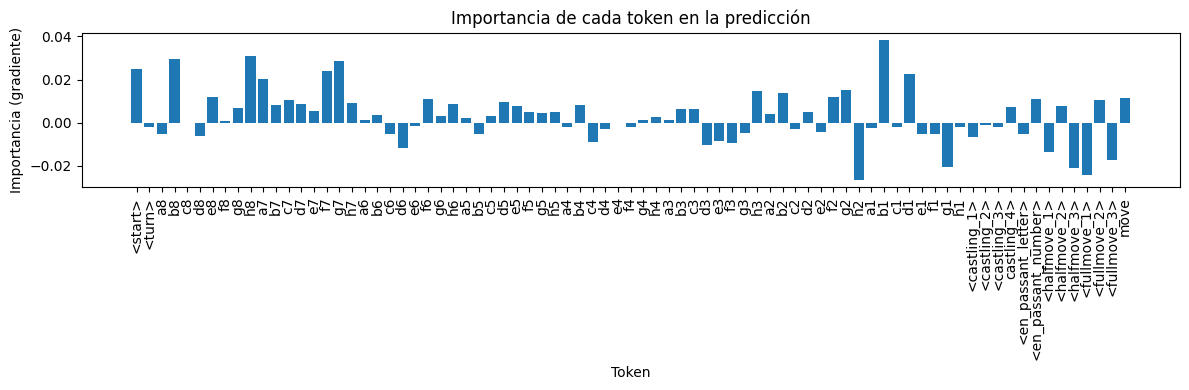

In [ ]:
bar_plot_token_importances(jacobians, token_labels)

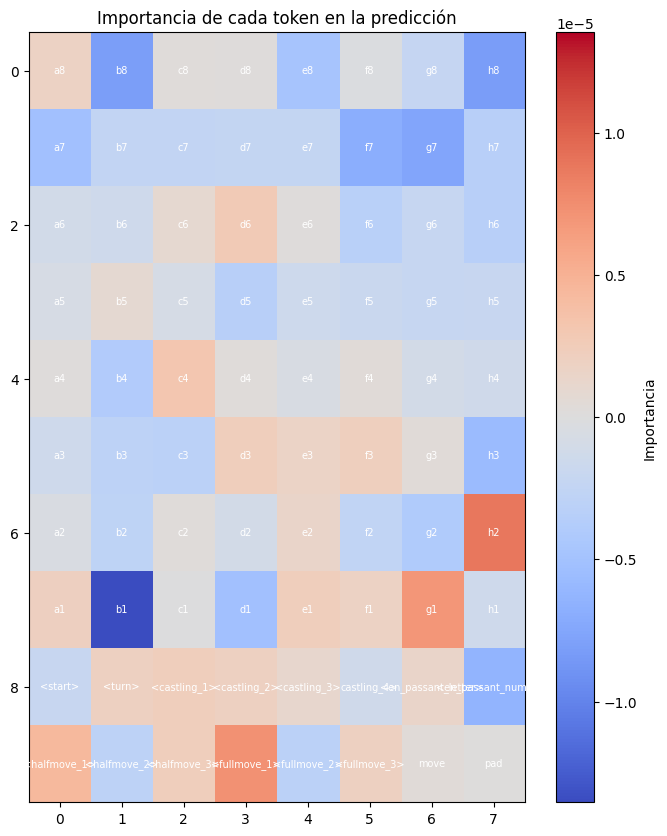

In [ ]:
board_plot_token_importances(gradients, token_labels)

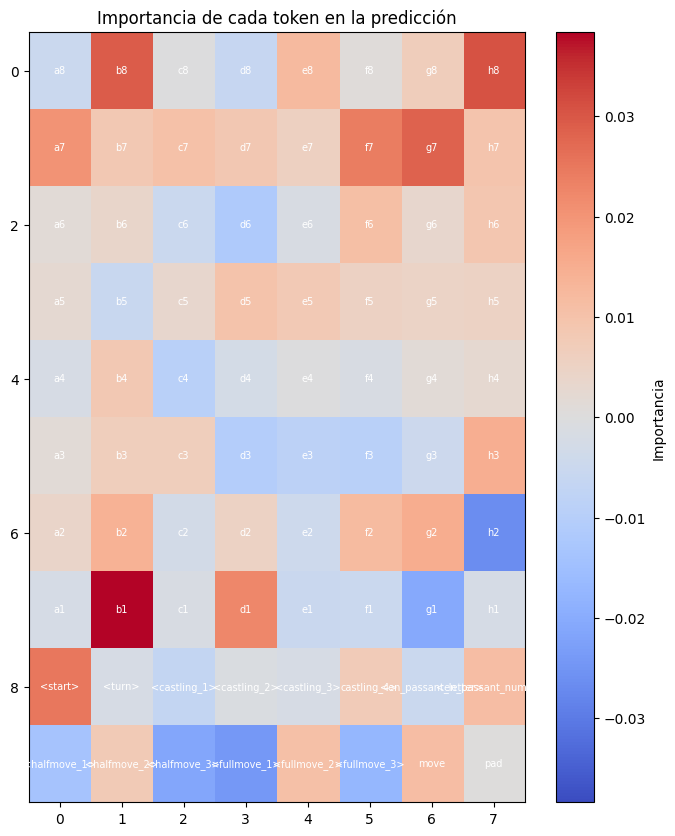

In [ ]:
board_plot_token_importances(jacobians, token_labels)

# Experimentos

In [ ]:
_, return_buckets_values = utils.get_uniform_buckets_edges_values(
    num_return_buckets
)

def experimento_xai(fen, max_moves=5, plot_raw_att=False, plot_board_att_by_rows = True, 
                    plot_board_att_by_cols=True, plot_token_imp=True,
                    save_path=None
                    ):
    
    # Creamos el tablero
    board = chess.Board(fen)
    # Obtenemos los pares tablero-jugada tokenizados
    sequences = get_sequences_from_board(board)
    # Predecimos los logits y mapas de atención
    results = predict_fn(sequences)
    logits = np.array([log[:,-1,:] for log, att in results])
    attention_maps = [att for log, att in results]
    attention_maps = np.array(attention_maps).reshape(-1, num_layers, num_heads, 79, 79)
    
    # Calculamos las probabilidades de victoria de cada jugada
    sorted_legal_moves = engine.get_ordered_legal_moves(board)
    win_probs = np.inner(np.exp(logits), return_buckets_values)
    win_probs = win_probs.flatten()
    
    # Reorganizar el diccionario
    reorganized_dict = {
        move.uci(): {
            "logits": logit.tolist() if isinstance(logit, np.ndarray) else logit,
            "win_probs": win_prob.tolist() if isinstance(win_prob, np.ndarray) else win_prob
        }
        for move, logit, win_prob in zip(sorted_legal_moves, logits, win_probs)
    }

    # Guardar en archivo JSON
    os.makedirs(save_path, exist_ok=True)
    with open(f'{save_path}/results.json', 'w') as f:
        json.dump(reorganized_dict, f, indent=2)
    
    if max_moves == None or max_moves > len(sorted_legal_moves):
        max_moves = len(sorted_legal_moves)
    
    # Ejecutamos los experimentos de xAI con las max_moves mejores jugadas
    for i in np.argsort(win_probs)[:-max_moves-1:-1]:
        print(f'  {sorted_legal_moves[i].uci()} -> {100*win_probs[i]:.1f}%')
        # Mapa de atención plano
        if plot_raw_att:
            os.makedirs(f'{save_path}/attention/79x79', exist_ok=True)
            plot_attention_maps(attention_maps[i], token_labels=token_labels, 
                                save_path=f'{save_path}/attention/79x79/_{sorted_legal_moves[i].uci()}.png')
            
        # Mapa de atención en el tablero
        if plot_board_att_by_rows:
            os.makedirs(f'{save_path}/attention/reordered_by_row', exist_ok=True)
            plot_all_attention_heads(attention_maps[i], token_labels=token_labels, by_row=True,
                                    save_path=f'{save_path}/attention/reordered_by_row/{sorted_legal_moves[i].uci()}.png')
        # Mapa de atención en el tablero (traspuesto)
        if plot_board_att_by_cols:
            os.makedirs(f'{save_path}/attention/reordered_by_col', exist_ok=True)
            plot_all_attention_heads(attention_maps[i], token_labels=token_labels, by_row=False,
                                save_path=f'{save_path}/attention/reordered_by_col/{sorted_legal_moves[i].uci()}.png')
        # Importancia de los tokens
        if plot_token_imp:
            os.makedirs(f'{save_path}/token_importances/bars', exist_ok=True)
            os.makedirs(f'{save_path}/token_importances/board', exist_ok=True)
            grads, jacs = compute_token_grad_importance(
                predictor,
                params,   
                sequences[i], 
                predictor_config
            )
            bar_plot_token_importances(grads, token_labels, save_path=f'{save_path}/token_importances/bars/{sorted_legal_moves[i].uci()}_grad.png')
            bar_plot_token_importances(jacs, token_labels, save_path=f'{save_path}/token_importances/bars/{sorted_legal_moves[i].uci()}_jac.png')
            bar_plot_token_importances(grads, token_labels, save_path=f'{save_path}/token_importances/board/{sorted_legal_moves[i].uci()}_grad.png')
            board_plot_token_importances(jacs, token_labels, save_path=f'{save_path}/token_importances/board/{sorted_legal_moves[i].uci()}_jac.png')
        
        gc.collect()

## Experimento 1: Primera jugada de blancas

In [ ]:
board1 = chess.Board()
fen1 = board1.fen()

In [ ]:
experimento_xai(fen1, max_moves=5, plot_raw_att=False, plot_board_att_by_rows = True, 
                plot_board_att_by_cols=True, plot_token_imp=True,
                save_path='xai/experiment1_batched')

  e2e4 -> 53.5%


/tmp/ipykernel_1687982/3124570349.py:62: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


  d2d4 -> 53.1%


/tmp/ipykernel_1687982/3124570349.py:62: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


  g1f3 -> 52.6%


/tmp/ipykernel_1687982/3124570349.py:62: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


  c2c4 -> 52.4%


/tmp/ipykernel_1687982/3124570349.py:62: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


  e2e3 -> 51.6%


/tmp/ipykernel_1687982/3124570349.py:62: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


## Experimento 2: Primera jugada de negras (1. e4)

In [ ]:
board2 = chess.Board()
board2.push(chess.Move.from_uci('e2e4'))
fen2 = board2.fen()

In [ ]:
experimento_xai(fen2, max_moves=5, plot_raw_att=False, plot_board_att_by_rows = True, 
                plot_board_att_by_cols=True, plot_token_imp=True,
                save_path='xai/experiment2_batched')

  c7c5 -> 47.0%


/tmp/ipykernel_1687982/3124570349.py:62: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


  e7e6 -> 46.3%


/tmp/ipykernel_1687982/3124570349.py:62: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


  e7e5 -> 46.2%


/tmp/ipykernel_1687982/3124570349.py:62: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


  d7d5 -> 45.6%


/tmp/ipykernel_1687982/3124570349.py:62: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


  c7c6 -> 44.7%


/tmp/ipykernel_1687982/3124570349.py:62: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


## Experimento 3 - Carrera de peón

In [ ]:
board3 = chess.Board('1k6/8/8/8/8/8/7P/1K6 w - - 0 1')
fen3 = board3.fen()

In [ ]:
experimento_xai(fen3, max_moves=5, plot_raw_att=False, plot_board_att_by_rows = True,
                plot_board_att_by_cols=True, plot_token_imp=True,
                save_path='xai/experiment3_batched')

  h2h4 -> 88.1%


/tmp/ipykernel_1687982/3124570349.py:62: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


  h2h3 -> 50.4%


/tmp/ipykernel_1687982/3124570349.py:62: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


  b1c2 -> 50.1%


/tmp/ipykernel_1687982/3124570349.py:62: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


  b1a1 -> 50.1%


/tmp/ipykernel_1687982/3124570349.py:62: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


  b1b2 -> 50.1%


/tmp/ipykernel_1687982/3124570349.py:62: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


## Experimento 4 - CorridorRooksWhite

In [ ]:
board4 = chess.Board('1k6/ppp4r/8/8/8/8/PPP3R1/1K6 w - - 0 1')
fen4 = board4.fen()

In [ ]:
experimento_xai(fen4, max_moves=5, plot_raw_att=False, plot_board_att_by_rows = True,
                plot_board_att_by_cols=True, plot_token_imp=True,
                save_path='xai/experiment4_batched')

  g2g8 -> 99.6%


/tmp/ipykernel_1687982/3124570349.py:62: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


  a2a4 -> 50.3%


/tmp/ipykernel_1687982/3124570349.py:62: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


  b2b3 -> 50.2%


/tmp/ipykernel_1687982/3124570349.py:62: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


  a2a3 -> 50.2%


/tmp/ipykernel_1687982/3124570349.py:62: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


  g2g1 -> 50.2%


/tmp/ipykernel_1687982/3124570349.py:62: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


## Experimento 4.2 - CorridorRooksBlack

In [ ]:
board4 = chess.Board('1k6/ppp4r/8/8/8/8/PPP3R1/1K6 b - - 0 1')
fen4 = board4.fen()

In [ ]:
experimento_xai(fen4, max_moves=5, plot_raw_att=False, plot_board_att_by_rows = True,
                plot_board_att_by_cols=True, plot_token_imp=True,
                save_path='xai/experiment4_batched/black')

  h7h1 -> 99.6%


/tmp/ipykernel_1687982/3124570349.py:62: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


  a7a5 -> 50.3%


/tmp/ipykernel_1687982/3124570349.py:62: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


  a7a6 -> 50.3%


/tmp/ipykernel_1687982/3124570349.py:62: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


  b7b6 -> 50.3%


/tmp/ipykernel_1687982/3124570349.py:62: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


  c7c6 -> 50.2%


/tmp/ipykernel_1687982/3124570349.py:62: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


## Experimento 5 - CrossMate

In [ ]:
board5 = chess.Board('k7/6b1/5q2/8/8/4Q3/5B2/1K6 w - - 0 1')
fen5 = board5.fen()

In [ ]:
experimento_xai(fen5, max_moves=5, plot_raw_att=False, plot_board_att_by_rows = True,
                plot_board_att_by_cols=True, plot_token_imp=True,
                save_path='xai/experiment5_batched')

  e3a7 -> 99.6%


/tmp/ipykernel_1687982/3124570349.py:62: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


  e3e8 -> 53.0%


/tmp/ipykernel_1687982/3124570349.py:62: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


  e3e4 -> 51.6%


/tmp/ipykernel_1687982/3124570349.py:62: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


  e3a3 -> 51.1%


/tmp/ipykernel_1687982/3124570349.py:62: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


  b1c2 -> 50.2%


/tmp/ipykernel_1687982/3124570349.py:62: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


## Diferencia de atenciones

### Experimento 1: Alteraciones en Pawn-Race

In [ ]:
board3 = chess.Board('1k6/8/8/8/8/8/7P/1K6 w - - 0 1')
# Obtenemos los pares tablero-jugada tokenizados
sequences_3 = get_sequences_from_board(board3)
# Predecimos los logits y mapas de atención
results_3 = predict_fn(sequences_3)
logits_3 = np.array([log[:,-1,:] for log, att in results_3])
attention_maps_3 = [att for log, att in results_3]
attention_maps_3 = np.array(attention_maps_3).reshape(-1, num_layers, num_heads, 79, 79)
# Calculamos las probabilidades de victoria de cada jugada
sorted_legal_moves_3 = engine.get_ordered_legal_moves(board3)
win_probs_3 = np.inner(np.exp(logits_3), return_buckets_values)
win_probs_3 = win_probs_3.flatten()

In [ ]:
print(win_probs_3)

[0.50075756 0.50035838 0.50030878 0.50066081 0.50076402 0.50403295
 0.88120345]


In [ ]:

logits_3 = np.array([log[:,-1,:] for log, att in results_3])
np.exp(logits_3)

array([[[1.56964985e-09, 1.88909804e-10, 1.17781465e-10, 1.70065934e-10,
         3.50727558e-10, 6.87473578e-10, 1.11134502e-09, 1.24371946e-09,
         2.16147167e-09, 3.35491857e-09, 3.59869134e-09, 2.82140356e-09,
         3.24170979e-09, 8.32138713e-09, 1.80754967e-08, 2.40383038e-08,
         2.35954936e-08, 2.10278177e-08, 1.90458458e-08, 1.86088389e-08,
         2.04686685e-08, 2.32549038e-08, 3.46234152e-08, 4.05590121e-08,
         5.95034315e-08, 7.02618408e-08, 6.83825618e-08, 7.01714455e-08,
         4.89323710e-08, 3.38074955e-08, 2.84727300e-08, 1.56229110e-08,
         1.09922160e-08, 7.58285346e-09, 4.81380846e-09, 3.74256093e-09,
         2.22070362e-09, 1.51809587e-09, 1.35624134e-09, 1.16773136e-09,
         1.30729827e-09, 1.43594237e-09, 1.50246848e-09, 2.30815367e-09,
         2.82607315e-09, 4.07850465e-09, 4.62723193e-09, 6.77664369e-09,
         8.65006911e-09, 1.32208839e-08, 1.52044386e-08, 2.01644799e-08,
         3.83981593e-08, 5.70345122e-08, 1.02759188

In [ ]:
ordered_indices_3 = np.argsort(win_probs_3)[::-1]
for i in ordered_indices_3:
    print(f'  {sorted_legal_moves_3[i].uci()} -> {100*win_probs_3[i]:.1f}%')

  h2h4 -> 88.1%
  h2h3 -> 50.4%
  b1c2 -> 50.1%
  b1a1 -> 50.1%
  b1b2 -> 50.1%
  b1c1 -> 50.0%
  b1a2 -> 50.0%


#### Diferencia entre jugar h4 (buena) y h3 (mala)

In [ ]:
attention_maps_3_h4 = attention_maps_3[ordered_indices_3[0]]
attention_maps_3_h3 = attention_maps_3[ordered_indices_3[1]]
diff_attention_map_3_h4_h3 = attention_maps_3_h4 - attention_maps_3_h3

In [ ]:
plot_all_attention_heads(diff_attention_map_3_h4_h3, token_labels, by_row=True, use_divergent_cmap=True,
                         save_path='xai/experiment3_batched/attention_comparatives/h4vsh3_row.png')

/tmp/ipykernel_1687982/3124570349.py:62: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


In [ ]:
plot_all_attention_heads(diff_attention_map_3_h4_h3, token_labels, by_row=False, use_divergent_cmap=True,
                         save_path='xai/experiment3_batched/attention_comparatives/h4vsh3_col.png')

/tmp/ipykernel_1675696/1417204334.py:62: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


#### Diferencia entre jugar h4 (buena) y Kc2 (mala)

In [ ]:
attention_maps_3_h4 = attention_maps_3[ordered_indices_3[0]]
attention_maps_3_Kc2 = attention_maps_3[ordered_indices_3[2]]
diff_attention_map_3_h4_Kc2 = attention_maps_3_h4 - attention_maps_3_Kc2

In [ ]:
plot_all_attention_heads(diff_attention_map_3_h4_Kc2, token_labels, by_row=True, use_divergent_cmap=True,
                         save_path='xai/experiment3_batched/attention_comparatives/h4vsKc3_row.png')

/tmp/ipykernel_1675696/1417204334.py:62: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


In [ ]:
plot_all_attention_heads(diff_attention_map_3_h4_Kc2, token_labels, by_row=False, use_divergent_cmap=True,
                         save_path='xai/experiment3_batched/attention_comparatives/h4vsKc3_col.png')

/tmp/ipykernel_1675696/1417204334.py:62: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


#### Diferencia entre jugar h3 (mala) y Kc2 (mala)

In [ ]:
attention_maps_3_h3 = attention_maps_3[ordered_indices_3[1]]
attention_maps_3_Kc2 = attention_maps_3[ordered_indices_3[2]]
diff_attention_map_3_h3_Kc2 = attention_maps_3_h3 - attention_maps_3_Kc2

In [ ]:
plot_all_attention_heads(diff_attention_map_3_h3_Kc2, token_labels, by_row=True, use_divergent_cmap=True,
                         save_path='xai/experiment3_batched/attention_comparatives/h3vsKc2_row.png')

/tmp/ipykernel_1676201/1417204334.py:62: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


In [ ]:
plot_all_attention_heads(diff_attention_map_3_h3_Kc2, token_labels, by_row=False, use_divergent_cmap=True,
                         save_path='xai/experiment3_batched/attention_comparatives/h3vsKc2_col.png')

/tmp/ipykernel_1676201/1417204334.py:62: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


#### Tablero Alternativo 1: Mover el peon de h2 a g2

In [ ]:
board3_alt1 = chess.Board('1k6/8/8/8/8/8/6P1/1K6 w - - 0 1')
# Obtenemos los pares tablero-jugada tokenizados
sequences_3_alt1 = get_sequences_from_board(board3_alt1)
# Predecimos los logits y mapas de atención
results_3_alt1 = predict_fn(sequences_3_alt1)
logits_3_alt1 = np.array([log[:,-1,:] for log, att in results_3_alt1])
attention_maps_3_alt1 = [att for log, att in results_3_alt1]
attention_maps_3_alt1 = np.array(attention_maps_3_alt1).reshape(-1, num_layers, num_heads, 79, 79)
# Calculamos las probabilidades de victoria de cada jugada
sorted_legal_moves_3_alt1 = engine.get_ordered_legal_moves(board3_alt1)
win_probs_3_alt1 = np.inner(np.exp(logits_3_alt1), return_buckets_values)
win_probs_3_alt1 = win_probs_3_alt1.flatten()

In [ ]:
ordered_indices_3_alt1 = np.argsort(win_probs_3_alt1)[::-1]
for i in ordered_indices_3_alt1:
    print(f'  {sorted_legal_moves_3_alt1[i].uci()} -> {100*win_probs_3_alt1[i]:.1f}%')

  b1c2 -> 70.1%
  b1c1 -> 54.7%
  b1b2 -> 54.5%
  b1a2 -> 51.2%
  b1a1 -> 50.7%
  g2g3 -> 50.7%
  g2g4 -> 50.4%


##### Comparativa Kc2

In [ ]:
attention_maps_3_Kc2_alt1 = attention_maps_3_alt1[ordered_indices_3_alt1[0]]
attention_maps_3_Kc2 = attention_maps_3[ordered_indices_3[2]]
diff_attention_map_3_Kc2_Kc2alt1 = attention_maps_3_Kc2 - attention_maps_3_Kc2_alt1

In [ ]:
plot_all_attention_heads(diff_attention_map_3_Kc2_Kc2alt1, token_labels, by_row=True, use_divergent_cmap=True,
                         save_path='xai/experiment3_batched/attention_comparatives/Kc2vsKc2alt1_row.png')
plot_all_attention_heads(diff_attention_map_3_Kc2_Kc2alt1, token_labels, by_row=False, use_divergent_cmap=True,
                         save_path='xai/experiment3_batched/attention_comparatives/Kc2vsKc2alt1_col.png')

/tmp/ipykernel_1676201/1417204334.py:62: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


#### Comparativa avance peones

In [ ]:
attention_maps_3_h4 = attention_maps_3[ordered_indices_3[0]]
attention_maps_3_g4_alt1 = attention_maps_3_alt1[ordered_indices_3_alt1[-1]]
diff_attention_map_3_h4_g4alt1 = attention_maps_3_h4 - attention_maps_3_g4_alt1

In [ ]:
plot_all_attention_heads(diff_attention_map_3_h4_g4alt1, token_labels, by_row=True, use_divergent_cmap=True,
                         save_path='xai/experiment3_batched/attention_comparatives/h4vsg4alt1_row.png')
plot_all_attention_heads(diff_attention_map_3_h4_g4alt1, token_labels, by_row=False, use_divergent_cmap=True,
                         save_path='xai/experiment3_batched/attention_comparatives/h4vsg4alt1_col.png')

/tmp/ipykernel_1676201/1417204334.py:62: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


#### Secuencia de avance del peón

In [ ]:
secuencia_movimientos = ['h2h4', 'b8c7', 'h4h5', 'c7d7', 'h5h6', 'd7e7', 'h6h7', 'e7f7', 'h7h8q']

In [ ]:
board3_avance = board3.copy()
logits_3_avance = []
attention_maps_3_avance = []

for move in secuencia_movimientos:
    
    sequences_3_avance = get_sequences_from_board(board3_avance)
    results_3_avance_i = predict_fn(sequences_3_avance)
    logits_3_avance_i = np.array([log[:,-1,:] for log, att in results_3_avance_i])
    attention_maps_3_avance_i = [att for log, att in results_3_avance_i]
    attention_maps_3_avance_i = np.array(attention_maps_3_avance_i).reshape(-1, num_layers, num_heads, 79, 79)
    
    logits_3_avance.append(logits_3_avance_i)
    attention_maps_3_avance.append(attention_maps_3_avance_i[engine.get_ordered_legal_moves(board3_avance)
                                                                 .index(chess.Move.from_uci(move))])
    
    board3_avance.push(chess.Move.from_uci(move))
    print(board3_avance.fen())

1k6/8/8/8/7P/8/8/1K6 b - - 0 1
8/2k5/8/8/7P/8/8/1K6 w - - 1 2
8/2k5/8/7P/8/8/8/1K6 b - - 0 2
8/3k4/8/7P/8/8/8/1K6 w - - 1 3
8/3k4/7P/8/8/8/8/1K6 b - - 0 3
8/4k3/7P/8/8/8/8/1K6 w - - 1 4
8/4k2P/8/8/8/8/8/1K6 b - - 0 4
8/5k1P/8/8/8/8/8/1K6 w - - 1 5
7Q/5k2/8/8/8/8/8/1K6 b - - 0 5


In [ ]:
for move, logits, attention_maps in zip(secuencia_movimientos, logits_3_avance, attention_maps_3_avance):
    print(f'Movimiento: {move}')
    print('Logits shape:', logits.shape)
    print('Attention maps shape:', attention_maps.shape)
    
    plot_all_attention_heads(attention_maps, token_labels, by_row=True, use_divergent_cmap=True,
                             save_path=f'xai/experiment3_batched/secuencia_avance/attention/reordered_by_row/{move}.png')
    
    plot_all_attention_heads(attention_maps, token_labels, by_row=False, use_divergent_cmap=True,
                             save_path=f'xai/experiment3_batched/secuencia_avance/attention/reordered_by_col/{move}.png')

Movimiento: e7f7
Logits shape: (8, 1, 128)
Attention maps shape: (8, 8, 79, 79)


/tmp/ipykernel_1698501/3124570349.py:62: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Movimiento: h7h8q
Logits shape: (9, 1, 128)
Attention maps shape: (8, 8, 79, 79)


#### Peon negro en h